# Econometrics Final Group Project

This is my working notebook on the `BeijingHouse.csv` dataset for the econometrics final group project based on [this article](https://towardsdatascience.com/predicting-house-prices-with-linear-regression-4fc427cb1002) and adding my own notes. -- Cinny

### Step 1: Import Libraries; Obtain and Clean Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
# import data
df = pd.read_csv('1.BeijingHouse.csv')
df.head(3)

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway
0,https://bj.lianjia.com/chengjiao/101084782030....,1.010000e+11,116.475489,40.019520,1.110000e+12,2016-08-09,1464,106,415.0,31680,...,1,1,1.0,2005,3,6,0.217,1,0,1
1,https://bj.lianjia.com/chengjiao/101086012217....,1.010000e+11,116.453917,39.881534,1.110000e+12,2016-07-28,903,126,575.0,43436,...,1,2,1.0,2004,4,6,0.667,1,1,0
2,https://bj.lianjia.com/chengjiao/101086041636....,1.010000e+11,116.561978,39.877145,1.110000e+12,2016-12-11,1271,48,1030.0,52021,...,1,3,4.0,2005,3,6,0.500,1,0,0


In [3]:
df.shape

(10629, 23)

In [4]:
df.columns

Index(['url', 'id', 'Lng', 'Lat', 'Cid', 'tradeTime', 'DOM', 'followers',
       'totalPrice', 'price', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
       'bathRoom', 'buildingType', 'constructionTime', 'renovationCondition',
       'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty',
       'subway'],
      dtype='object')

In [5]:
df.dtypes

url                     object
id                     float64
Lng                    float64
Lat                    float64
Cid                    float64
tradeTime               object
DOM                      int64
followers                int64
totalPrice             float64
price                    int64
square                 float64
livingRoom               int64
drawingRoom              int64
kitchen                  int64
bathRoom                 int64
buildingType           float64
constructionTime        object
renovationCondition      int64
buildingStructure        int64
ladderRatio            float64
elevator                 int64
fiveYearsProperty        int64
subway                   int64
dtype: object

- `price`: the average price by square
- `totalPrice`: the total price

### Step 2: Exploratory Data Analysis (EDA)

In [14]:
sns.set_palette('Greys_r')
sns.set_style('whitegrid')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [7]:
full_corr_matrix = df.corr()[
    ['Lng', 'Lat', 'Cid', 'DOM', 'followers',
     'totalPrice', 'price', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
     'bathRoom', 'buildingType', 'renovationCondition', 'buildingStructure', 
     'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway']]

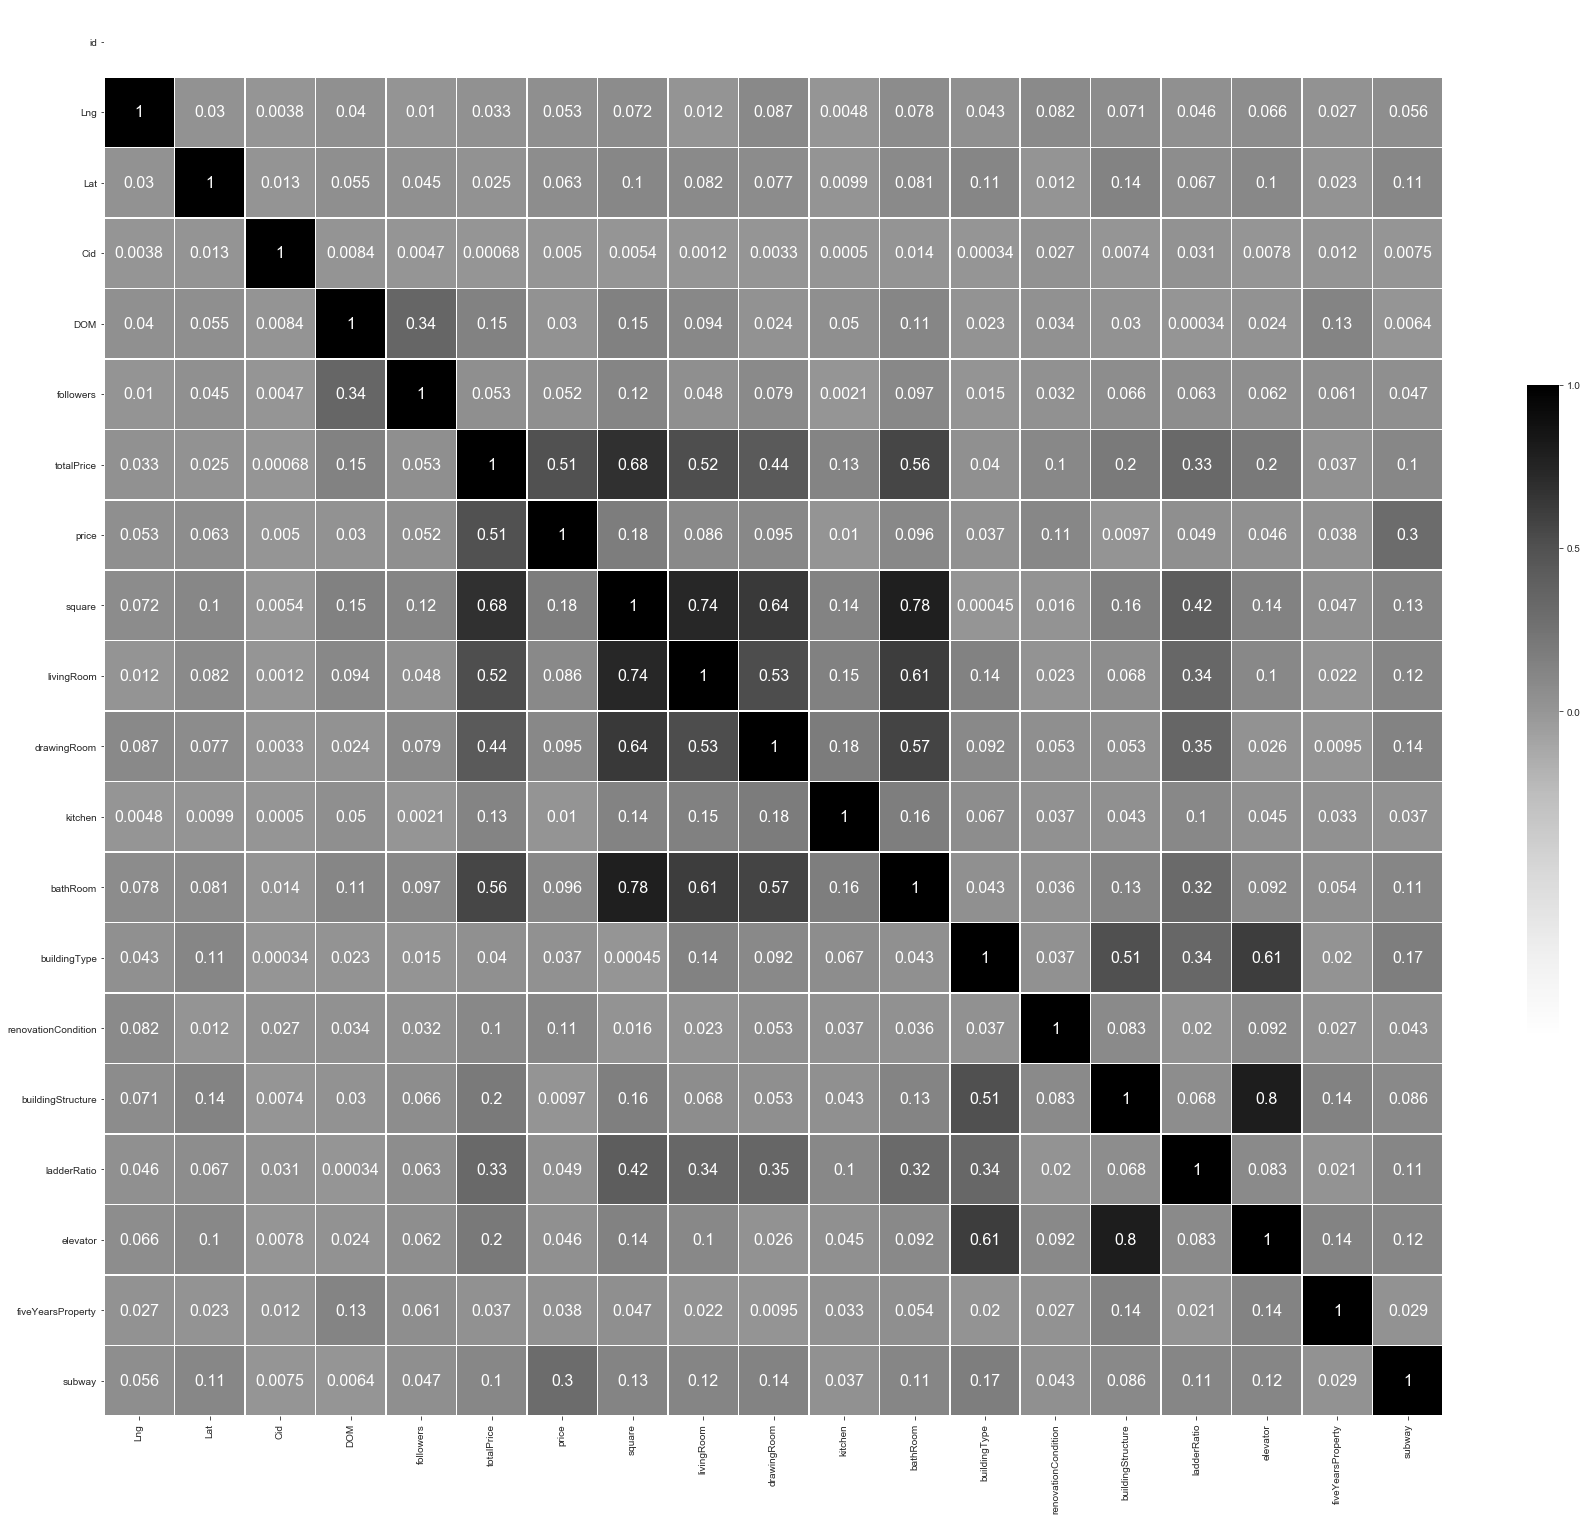

In [8]:
f, ax = plt.subplots(figsize=(30, 30))
columns = ['Lng', 'Lat', 'Cid', 'DOM', 'followers', 'totalPrice', 'price',
       'square', 'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom',
       'buildingType', 'renovationCondition', 'buildingStructure',
       'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway']

heatmap = sns.heatmap(abs(full_corr_matrix),
                      square = True,
                      linewidths = .5,
                      #cmap = 'coolwarm',
                      cmap = 'Greys',
                      cbar_kws = {'shrink': .4,
                                #'ticks' : [-1, -.5, 0, 0.5, 1]},
                                  'ticks' : [0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 16})

#add the column names as labels
ax.set_yticklabels(['id']+columns, rotation = 0)
ax.set_xticklabels(full_corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
sns.set(font_scale=2)

plt.savefig('full_corr_matrix_abs.png')

This correlation matrix heatmap is a visual representation of how each variable is correlated. For our purposes, we can focus on looking at different variables correlation with `totalPrice`.

In [9]:
corr_matrix = df.corr()[['totalPrice']].sort_values('totalPrice')
corr_target = abs(corr_matrix)

In [10]:
salient_num_features = corr_target.loc[corr_target['totalPrice'] > 0.5, :]
salient_num_features

,totalPrice
price,0.506238
livingRoom,0.515816
bathRoom,0.563007
square,0.680122
totalPrice,1.000000


This means that `price`, `livingRoom`, `bathRoom`, `square` are the variables with higher correlation (`>0.5`) with `totalPrice`.

In [11]:
corr_target2 = abs(df.corr()[['price']].sort_values('price'))
corr_target2.loc[corr_target2['price']>0.5]

,price
totalPrice,0.506238
price,1.000000


Just as a cofirmation, we can see that `totalPrice` is a better metric than `price` (average price by square) for understanding correlation.

**After discussions we still think `price` should be more suitable as the dependent variable, and the reason why we are not seeing correlation immediately is probably because the features have not been engineered.**

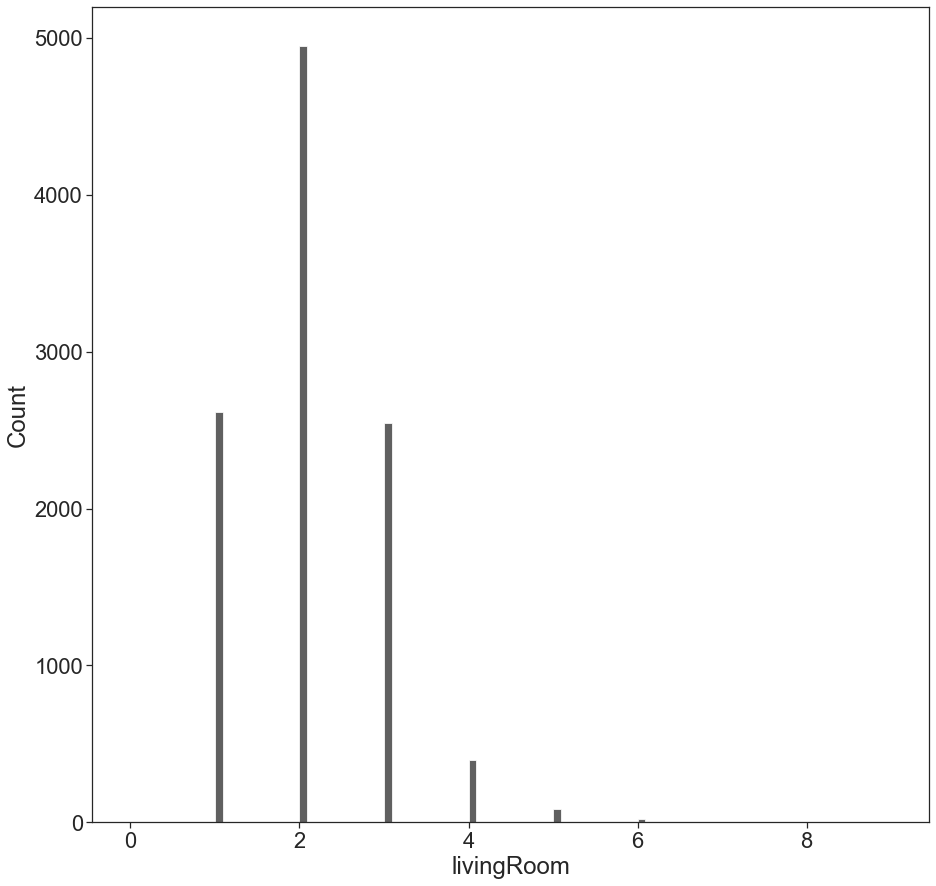

In [21]:
plt.figure(figsize=(15,15))
#plt.hist(df['livingRoom'])
sns.histplot(data=df, x='livingRoom')
plt.show()

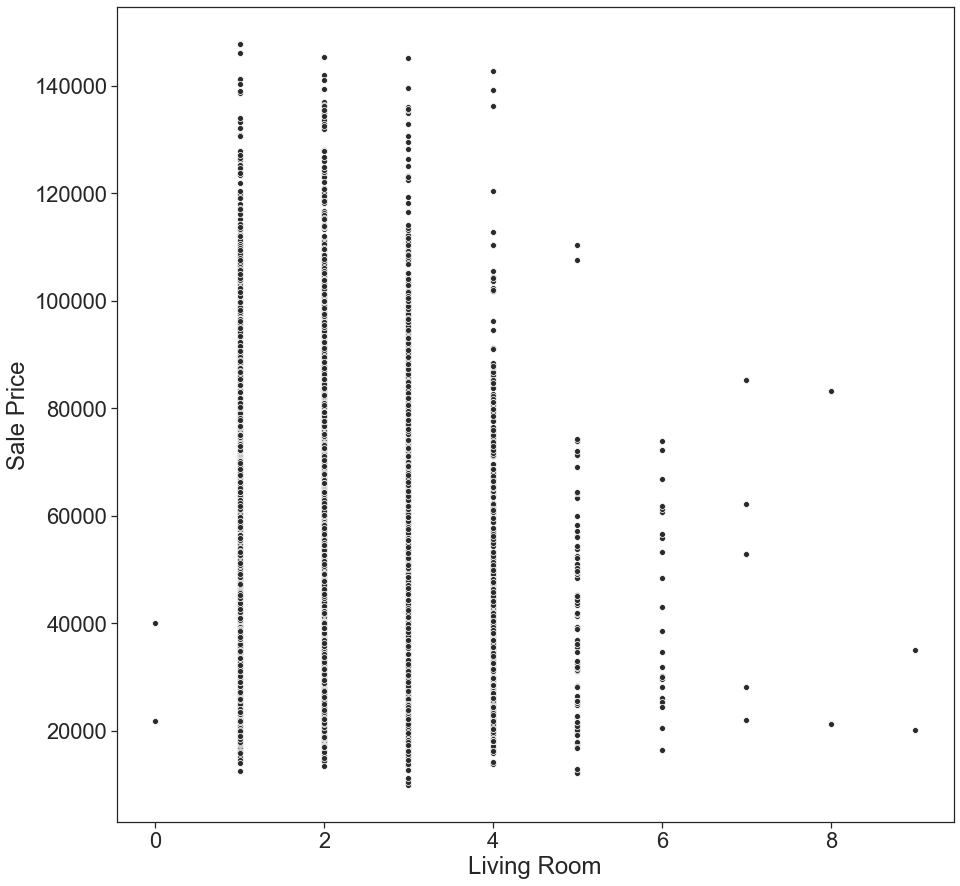

In [187]:
plt.figure(figsize=(15,15))
#plt.scatter(df['livingRoom'], df['totalPrice'], alpha=0.5)
#plt.scatter(df['livingRoom'], df['price'], alpha=0.5)
sns.scatterplot(data=df, x='livingRoom', y='price')
plt.xlabel('Living Room')
plt.ylabel('Sale Price')
plt.savefig('livingRoom.png')
plt.show()

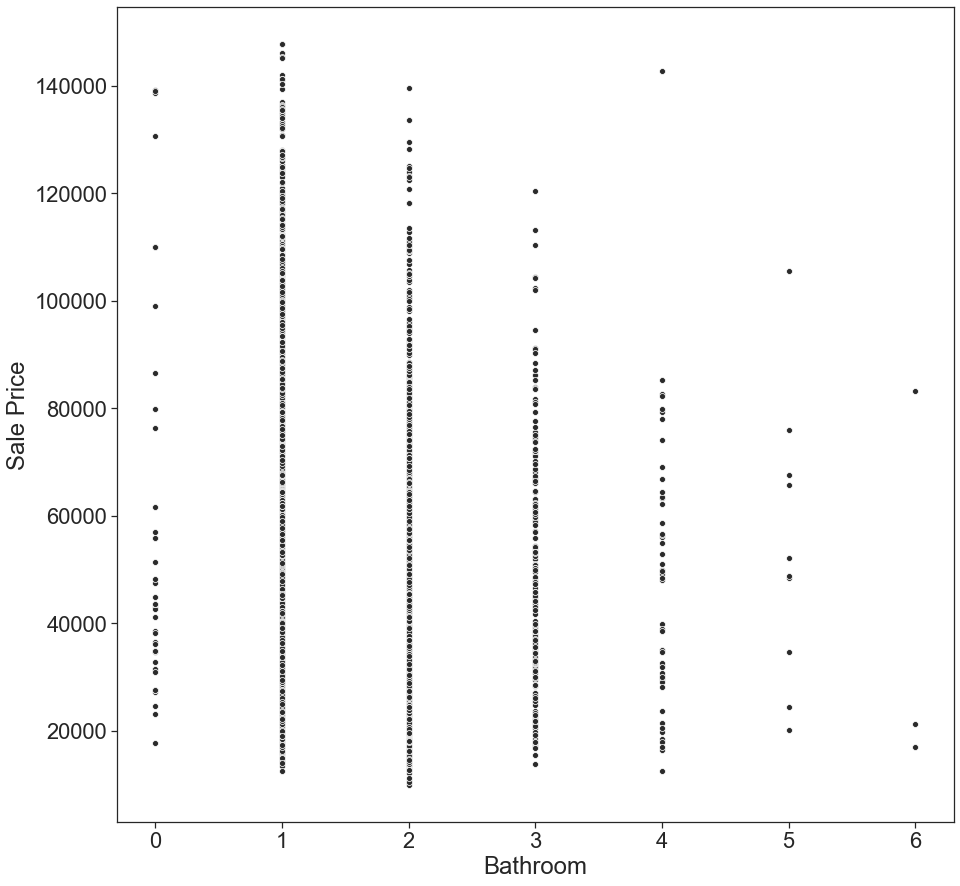

In [206]:
plt.figure(figsize=(15,15))
#plt.scatter(df['bathRoom'], df['totalPrice'], alpha=0.5)
#plt.scatter(df['bathRoom'], df['price'], alpha=0.5)
sns.scatterplot(data=df, x='bathRoom', y='price')
plt.xlabel('Bathroom')
plt.ylabel('Sale Price')
plt.savefig('bathRoom.png')
plt.show()

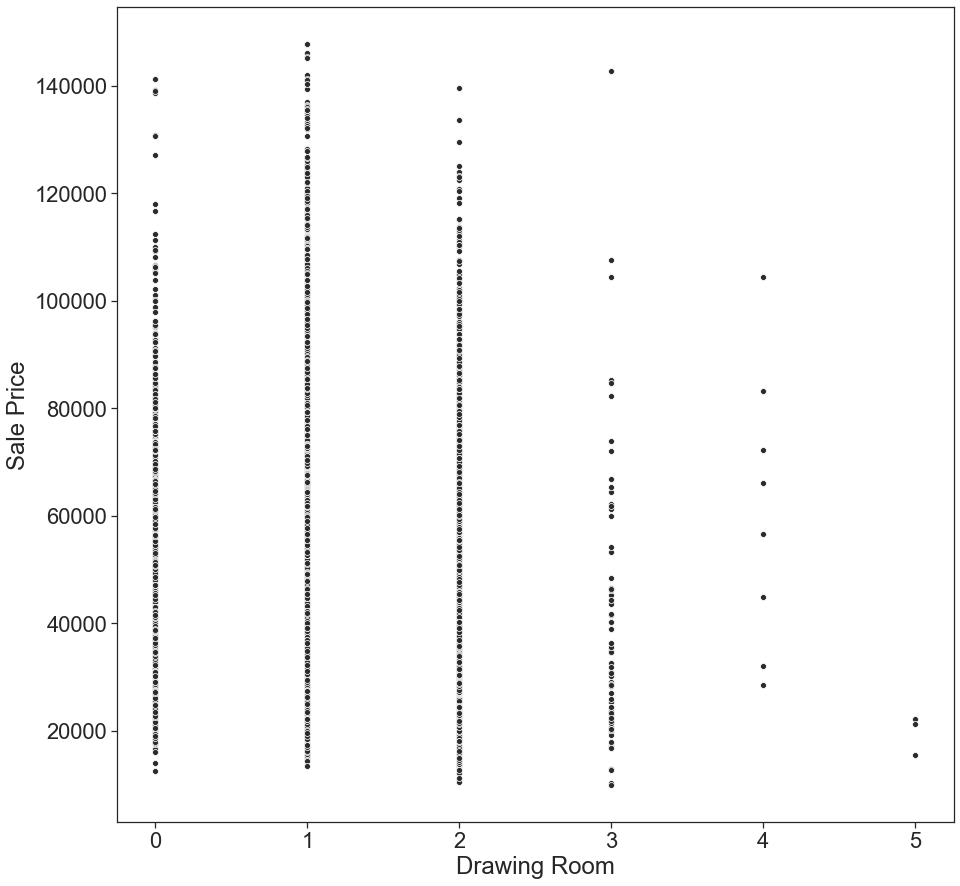

In [241]:
plt.figure(figsize=(15,15))
#plt.scatter(df['drawingRoom'], df['totalPrice'], alpha=0.5)
#plt.scatter(df['drawingRoom'], df['price'], alpha=0.5)
sns.scatterplot(data=df, x='drawingRoom', y='price')
plt.xlabel('Drawing Room')
plt.ylabel('Sale Price')
plt.savefig('drawingRoom.png')
plt.show()

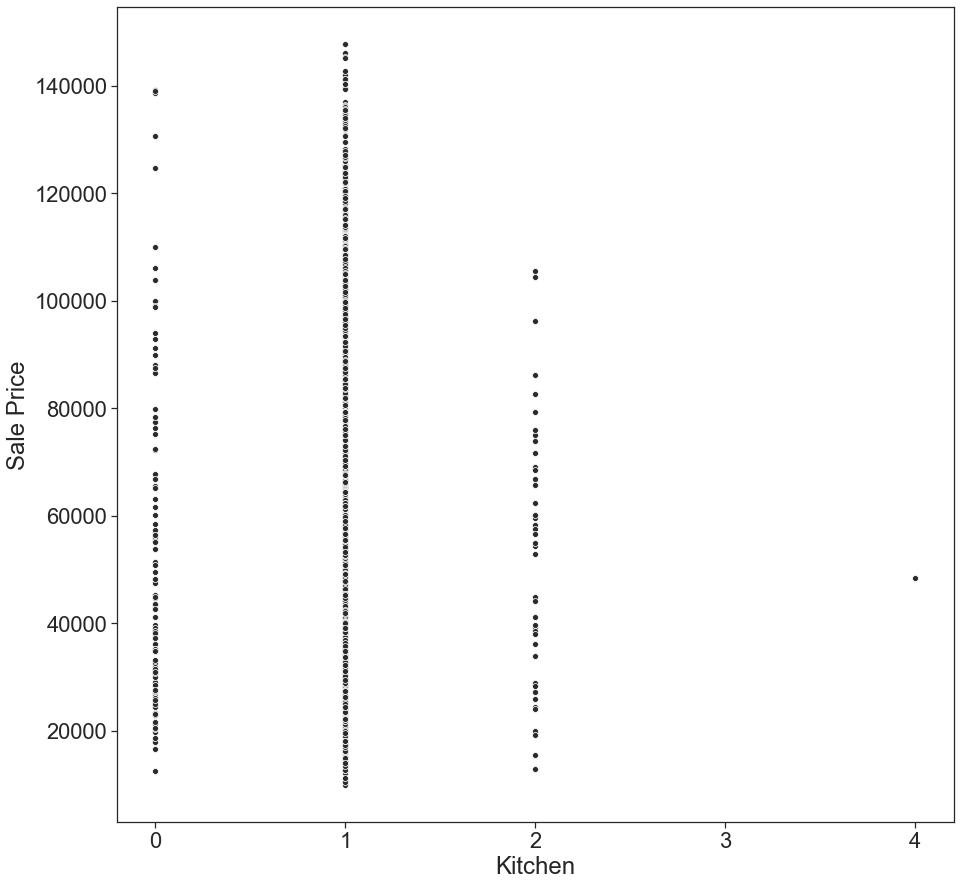

In [243]:
plt.figure(figsize=(15,15))
#plt.scatter(df['kitchen'], df['totalPrice'], alpha=0.5)
#plt.scatter(df['kitchen'], df['price'], alpha=0.5)
sns.scatterplot(data=df, x='kitchen', y='price')
plt.xticks([0,1,2,3,4])
plt.xlabel('Kitchen')
plt.ylabel('Sale Price')
plt.savefig('kitchen.png')
plt.show()

`ladderRatio`: the proportion between number of residents on the same floor and number of elevator of ladder.

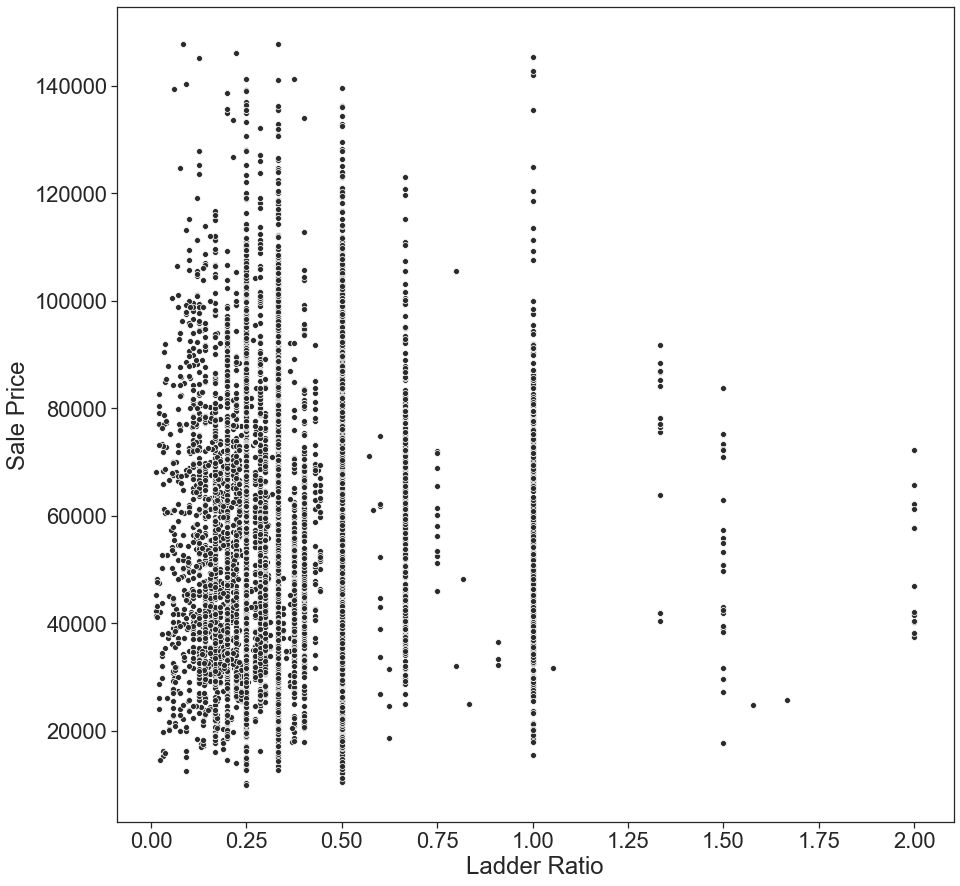

In [260]:
plt.figure(figsize=(15,15))
#plt.scatter(df['ladderRatio'], df['totalPrice'], alpha=0.5)
#plt.scatter(df['ladderRatio'], df['price'], alpha=0.5)
sns.scatterplot(data=df, x='ladderRatio', y='price')
plt.xlabel('Ladder Ratio')
plt.ylabel('Sale Price')
plt.savefig('ladderRatio.png')
plt.show()

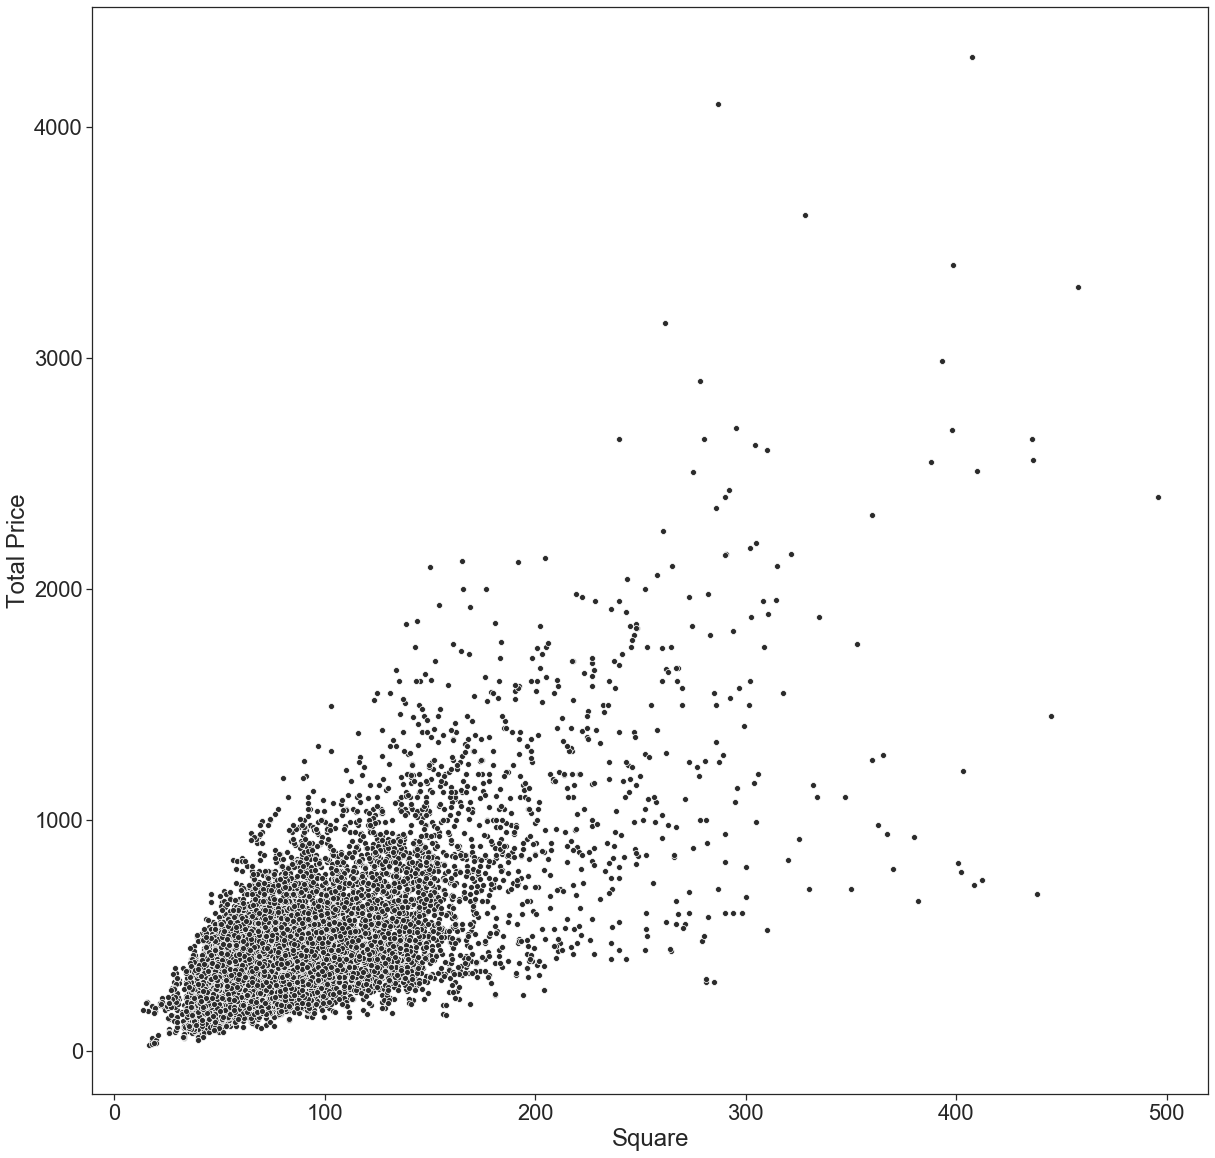

In [207]:
plt.figure(figsize=(20,20))
sns.scatterplot(data=df, x='square', y='totalPrice')
#plt.scatter(df['square'], df['totalPrice'], alpha=0.3)
#plt.scatter(df['square'], df['price'], alpha=0.3)
plt.xlabel('Square')
plt.ylabel('Total Price')
#plt.savefig('square.png')
plt.show()

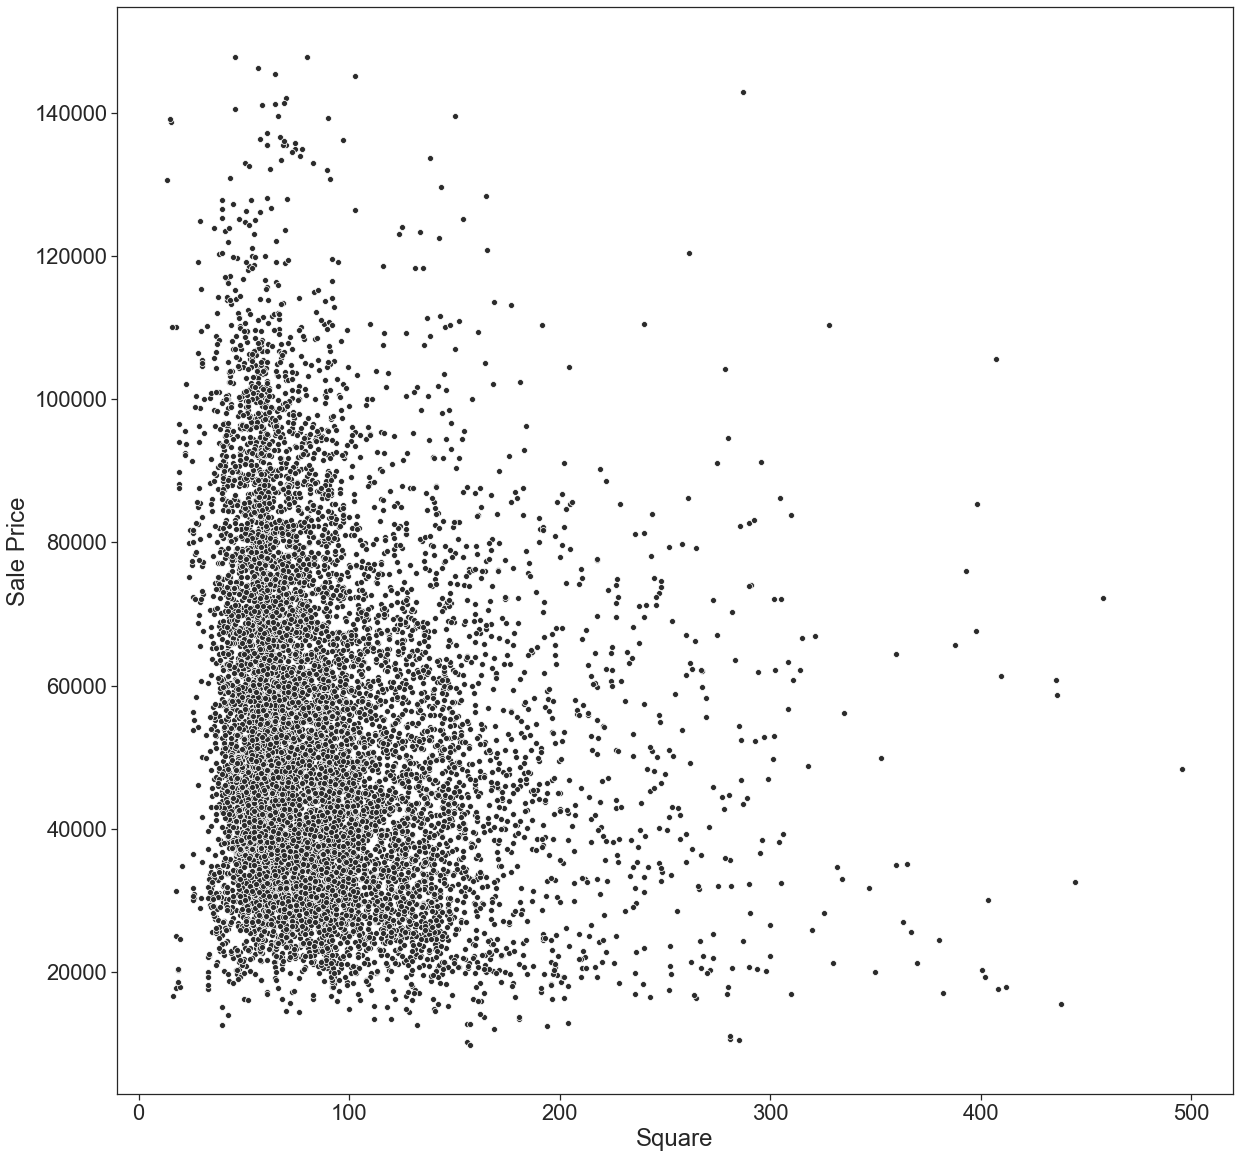

In [265]:
plt.figure(figsize=(20,20))
#plt.scatter(df['square'], df['totalPrice'], alpha=0.3)
#plt.scatter(df['square'], df['price'], alpha=0.3)
sns.scatterplot(data=df, x='square', y='price')
#sns.regplot(data=df, x='square', y='price')
plt.xlabel('Square')
plt.ylabel('Sale Price')
plt.savefig('square.png')
plt.show()

This was not part of the author's tutorial but I think since these are numerical data it would be useful for us to see correlation from scatter plots. I haven't done too much interpretation with it yet though.

**Also, using `price` probably does make more sense, looking at the `price` and `square` comparison alone, we can see that it is much more interpretable than using `totalPrice`.**

Originally, we see that `totalPrice` is higher when `square` is bigger, which is self-explanatory and doesn't say much about the data. 

But using `price`, we can see that when the `square` is small, the `price` range varies dramatically, probably because smaller houses represent houses closer to the city center, and house price in the city varies a lot. On the other hand, we see that houses with larger squares generally have lower prices overall. 

This reminds me of something! Assuming Temple of Heaven as the city center, using lattitude and longtitude difference probably makes more sense than using the value itself!! 

Temple of Heaven (`39.8822° N, 116.4066° E`)

In [152]:
df['Lng_diff'] = abs(df['Lng']-116.4066)
df['Lat_diff'] = abs(df['Lat']-39.8822)

In [157]:
df['Lng_quad'] = df['Lng']**2
df['Lat_quad'] = df['Lat']**2

In [158]:
abs(df.corr()[['price']].sort_values('price'))[:10]

,price
Lng_diff,0.433124
Lat_diff,0.337443
constructionTime,0.290223
square,0.175438
bathRoom,0.095624
drawingRoom,0.095191
livingRoom,0.086313
Lat_quad,0.064379
Lat,0.063447
Lng_quad,0.053154


The correlation for location dramatically increased after using the difference! We're on the right track!!!

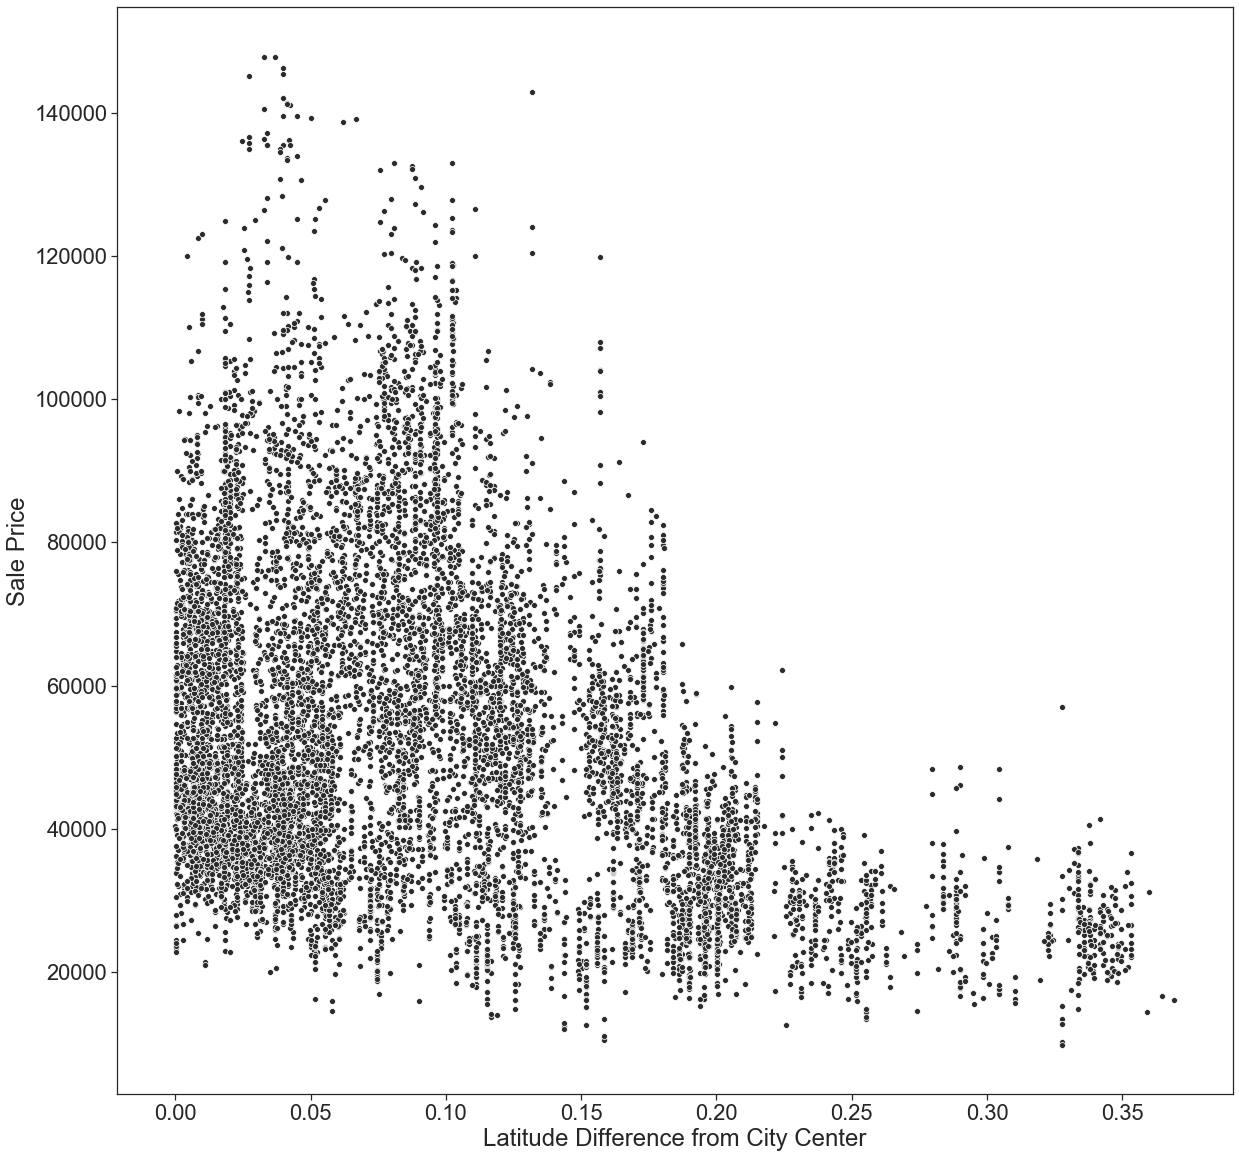

In [209]:
plt.figure(figsize=(20,20))
#plt.scatter(df['Lat_diff'], df['price'], alpha=0.3)
sns.scatterplot(data=df, x='Lat_diff', y='price')
plt.xlabel('Latitude Difference from City Center')
plt.ylabel('Sale Price')
plt.savefig('lat_diff.png')
plt.show()

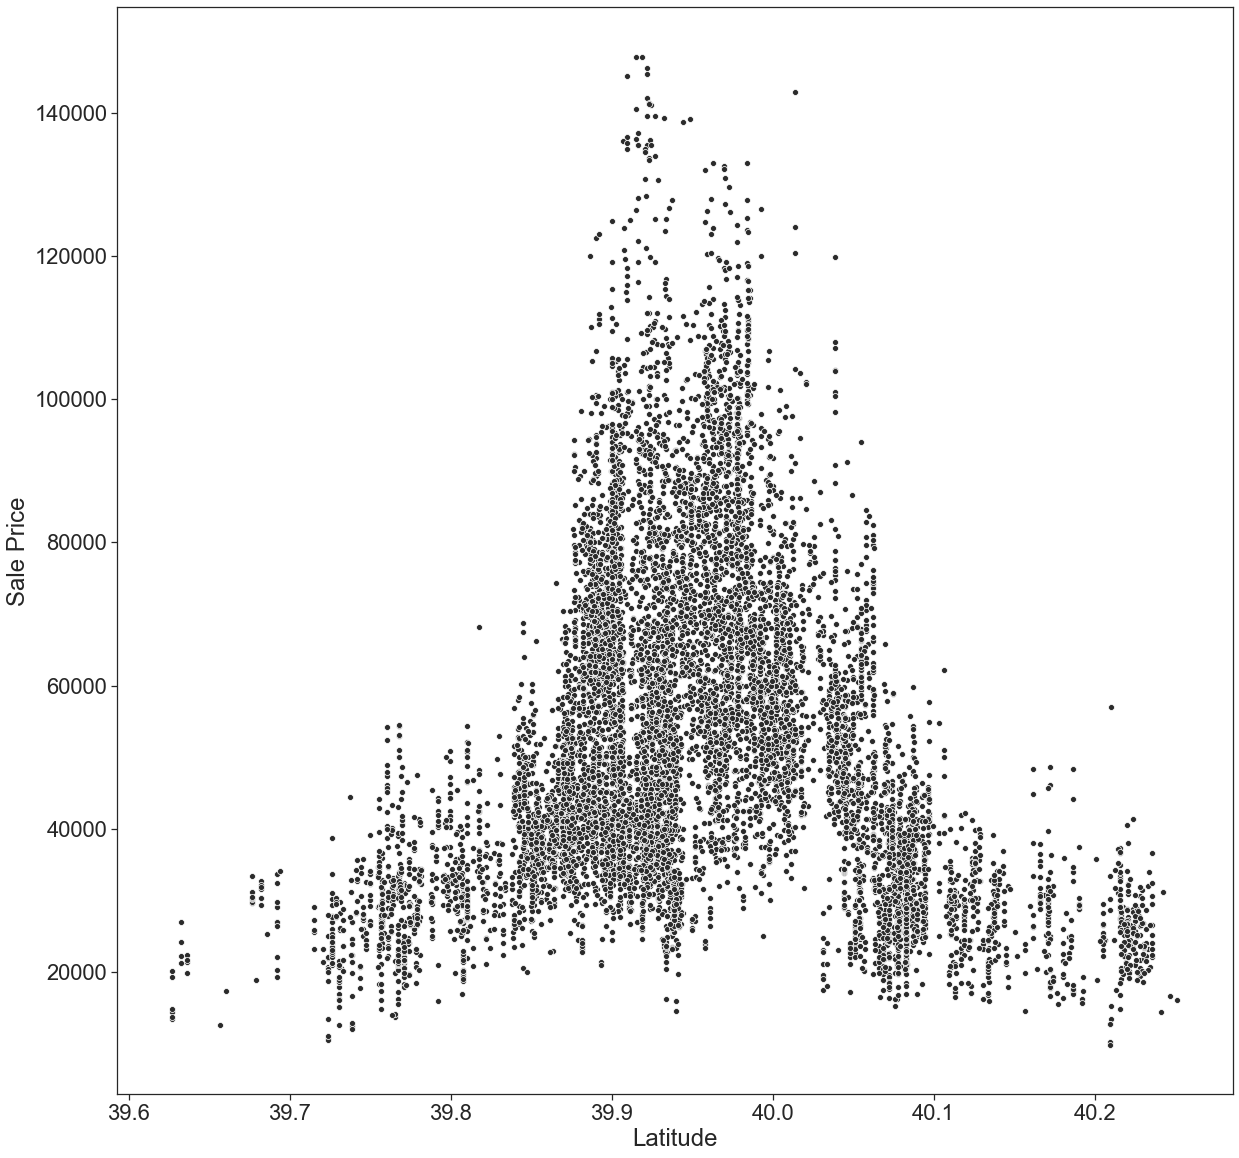

In [271]:
plt.figure(figsize=(20,20))
#plt.scatter(df['Lat'], df['price'], alpha=0.3)
sns.scatterplot(data=df, x='Lat', y='price')
#sns.regplot(data=df, x='Lat', y='price')
#sns.regplot(data=df, x='Lat', y='price', order=3)
plt.xlabel('Latitude')
plt.ylabel('Sale Price')
plt.savefig('lat.png')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


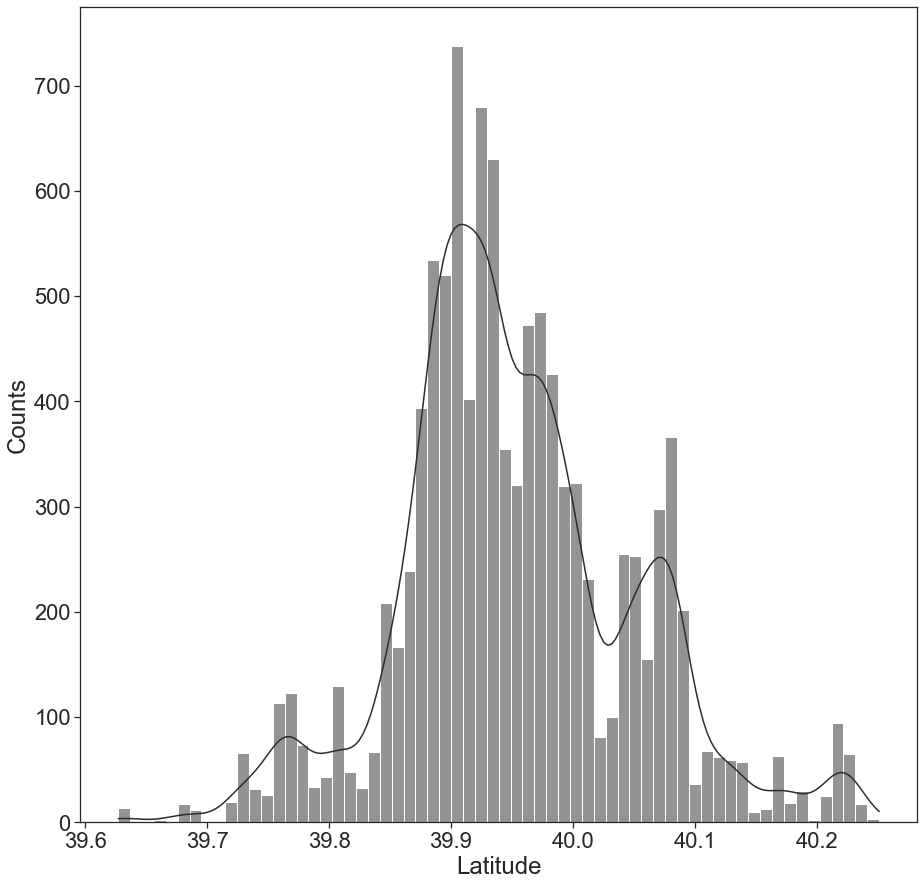

In [25]:
plt.figure(figsize=(15,15))
#plt.hist(df['Lat'])
sns.histplot(data=df, x='Lat', kde=True)
plt.xlabel('Latitude')
plt.ylabel('Counts')
plt.savefig('lat_hist.png')
plt.show()

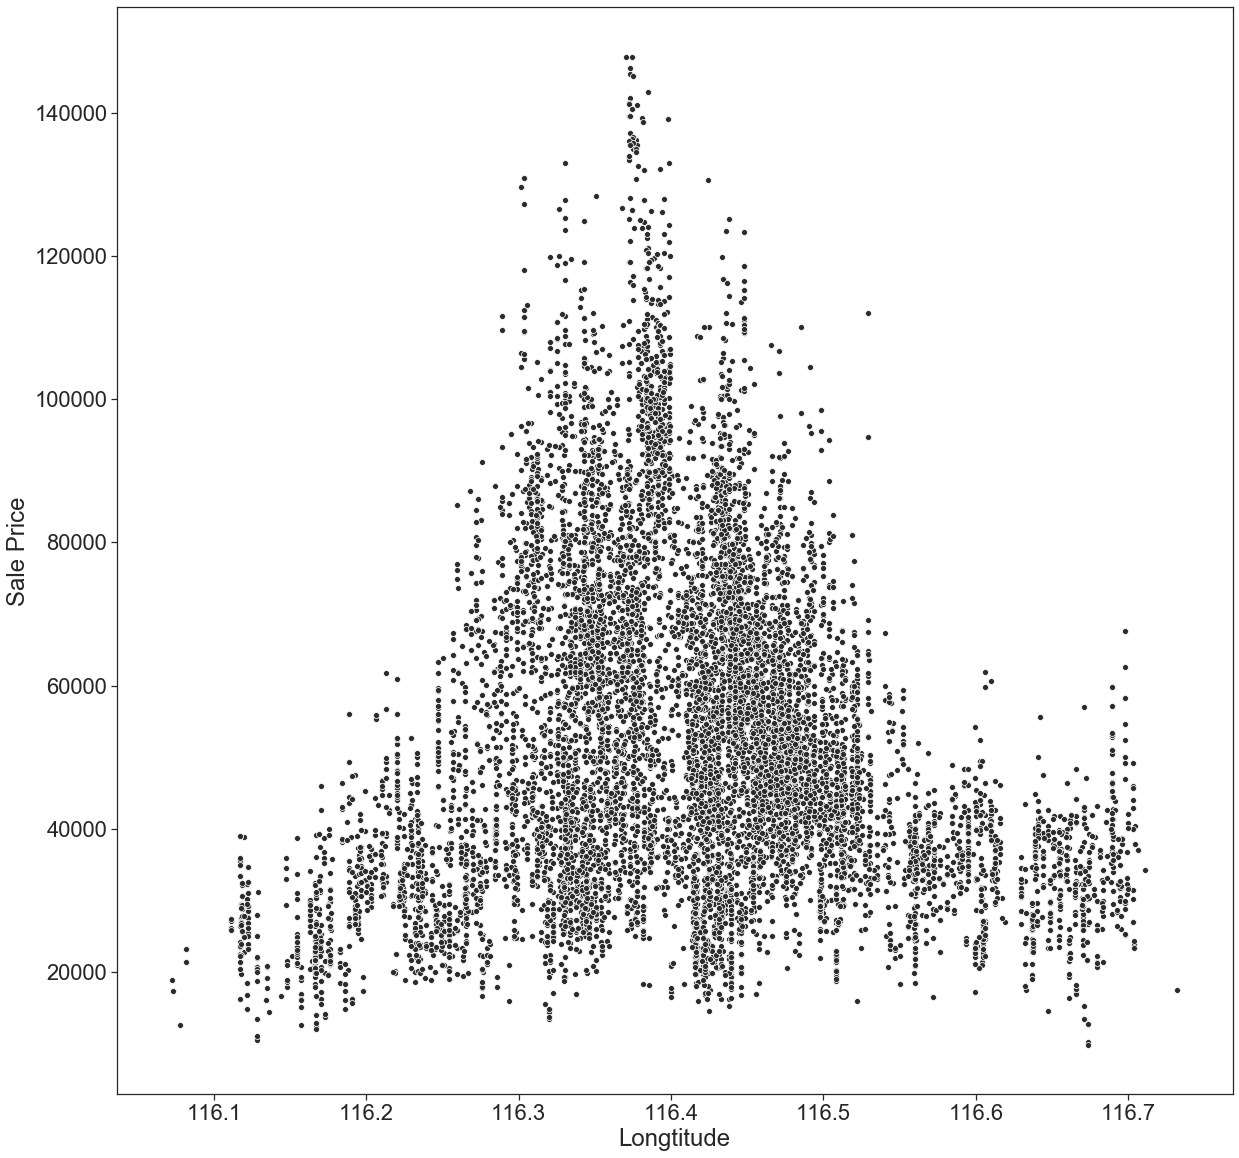

In [211]:
plt.figure(figsize=(20,20))
#plt.scatter(df['Lng'], df['price'], alpha=0.3)
sns.scatterplot(data=df, x='Lng', y='price')
plt.xlabel('Longtitude')
plt.ylabel('Sale Price')
plt.savefig('lng.png')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


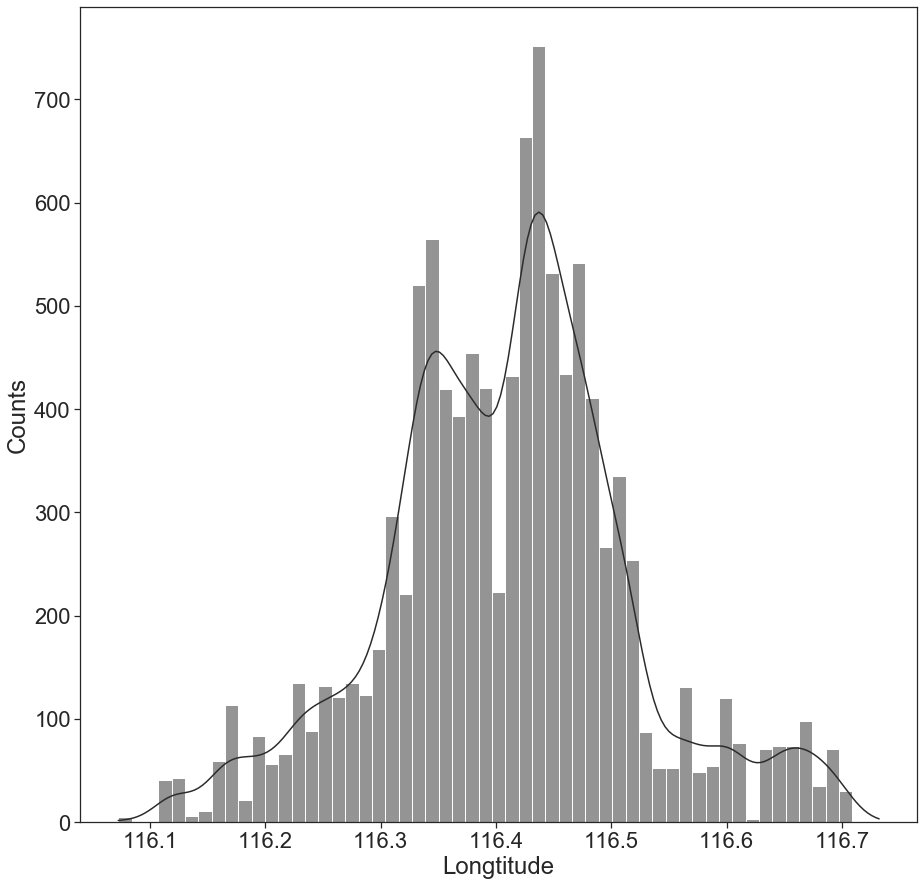

In [26]:
plt.figure(figsize=(15,15))
#plt.hist(df['Lng'])
sns.histplot(data=df, x='Lng', kde=True)
plt.xlabel('Longtitude')
plt.ylabel('Counts')
plt.savefig('lng_hist.png')
plt.show()

We're definetely on the right track. Latitude and longtitude matter significantly for the price. Prices are higher when closer to city center.

This next method is for dealing with categorical variables. 

The original dataset that the author was dealing with has almost 100 features, we only have 23, so we can still use OneHotEncoding as well as the method the author used.

Let's first use the method the author advised, since it is straightforward to see from a visual representation.

No variables with high covariance with our `totalPrice` is a categorical variable in our dataset (`price`, `livingRoom`, `bathRoom`, `square` are all numerical). 

Note that this is because categorical variables in the dataset has been coded with numerical values, but those numbers are arbitrary. This means that we won't see a high correlation from categorical variables in the correlation matrix and heatmap, but that does not mean that they are not useful metrics for predicting price!

The categorical variables in our dataset are `buildingType`, `renovationCondition`, `buildingStructure`; `elevator` and `subway` are binary; and `constructionTime` is ordinal. 

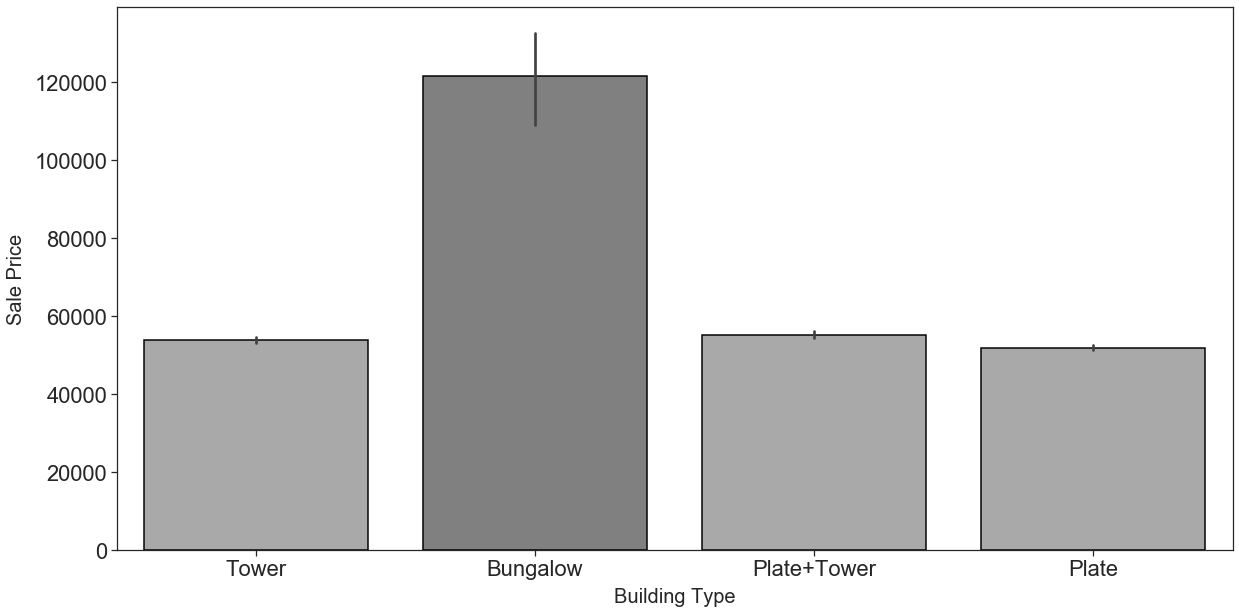

In [244]:
plt.figure(figsize = (20,10))
ax = sns.barplot(x = 'buildingType', y = 'price', data = df,
                 palette = ['darkgray', 'gray', 'darkgray', 'darkgray'], 
                 linewidth = 1.5, edgecolor = 'black')
plt.xlabel('Building Type', 
           fontdict = {'fontsize':20}, labelpad = 8)
plt.ylabel('Sale Price', fontdict = {'fontsize':20}, labelpad = 8)
ax.set_xticklabels(['Tower', 'Bungalow', 'Plate+Tower', 'Plate'])
plt.savefig('buildingType.png')

It seems that in terms of `buildingType`, `tower`, `plate+tower`, and `plate` are similar, while `bungalow` is different from the other three categories.

In [15]:
#df['buildingType1'] = df['buildingType'].map(lambda x: 1 if x in [1.0, 3.0, 4.0] else 0)
#df['buildingType2'] = df['buildingType'].map(lambda x: 1 if x in [2.0] else 0)
#df.drop(columns = 'buildingType', inplace = True)

In [29]:
df['buildingType1'] = df['buildingType'].map(lambda x: 1 if x in [1.0] else 0)
df['buildingType2'] = df['buildingType'].map(lambda x: 1 if x in [2.0] else 0)
df['buildingType3'] = df['buildingType'].map(lambda x: 1 if x in [3.0] else 0)
df['buildingType4'] = df['buildingType'].map(lambda x: 1 if x in [4.0] else 0)
#df.drop(columns = 'buildingType', inplace = True)

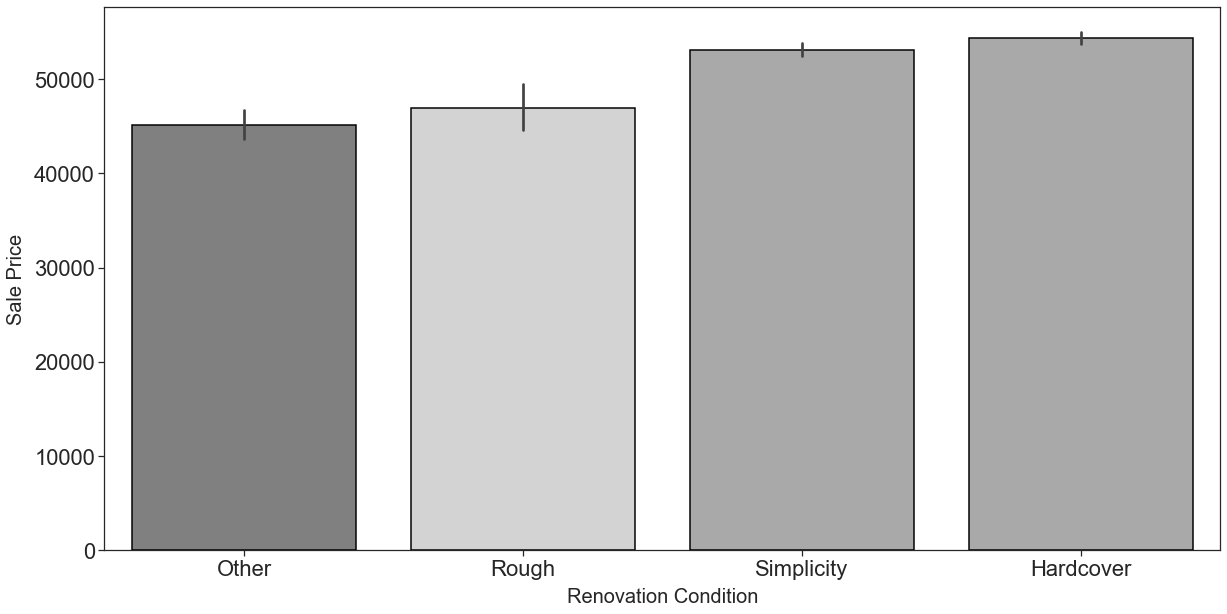

In [246]:
plt.figure(figsize = (20,10))
ax = sns.barplot(x = 'renovationCondition', y = 'price', data = df,
                 palette = ['gray', 'lightgray', 'darkgray', 'darkgray'], 
                 linewidth = 1.5, edgecolor = 'black')
plt.xlabel('Renovation Condition', 
           fontdict = {'fontsize':20}, labelpad = 8)
plt.ylabel('Sale Price', fontdict = {'fontsize':20}, labelpad = 8)
ax.set_xticklabels(['Other', 'Rough', 'Simplicity', 'Hardcover'])
plt.savefig('renovationCondition.png')

It seems that in terms of `renovationCondition`, `Other` and `Simplicity` are similar, and `Rough` and `Hardcover` are similar.

In [18]:
#df['renovationCondition1'] = df['renovationCondition'].map(lambda x: 1 if x in [1, 3] else 0)
#df['renovationCondition2'] = df['renovationCondition'].map(lambda x: 1 if x in [2, 4] else 0)
#df.drop(columns = 'renovationCondition', inplace = True)

In [222]:
df['renovationCondition1'] = df['renovationCondition'].map(lambda x: 1 if x in [1] else 0)
df['renovationCondition2'] = df['renovationCondition'].map(lambda x: 1 if x in [2] else 0)
df['renovationCondition3'] = df['renovationCondition'].map(lambda x: 1 if x in [3] else 0)
df['renovationCondition4'] = df['renovationCondition'].map(lambda x: 1 if x in [4] else 0)
#df.drop(columns = 'renovationCondition', inplace = True)

Even though I color-coded `Simplicity` and `Other` differently, I put them in the same category while coding. This may have bias so we could also try dropping `Other`.

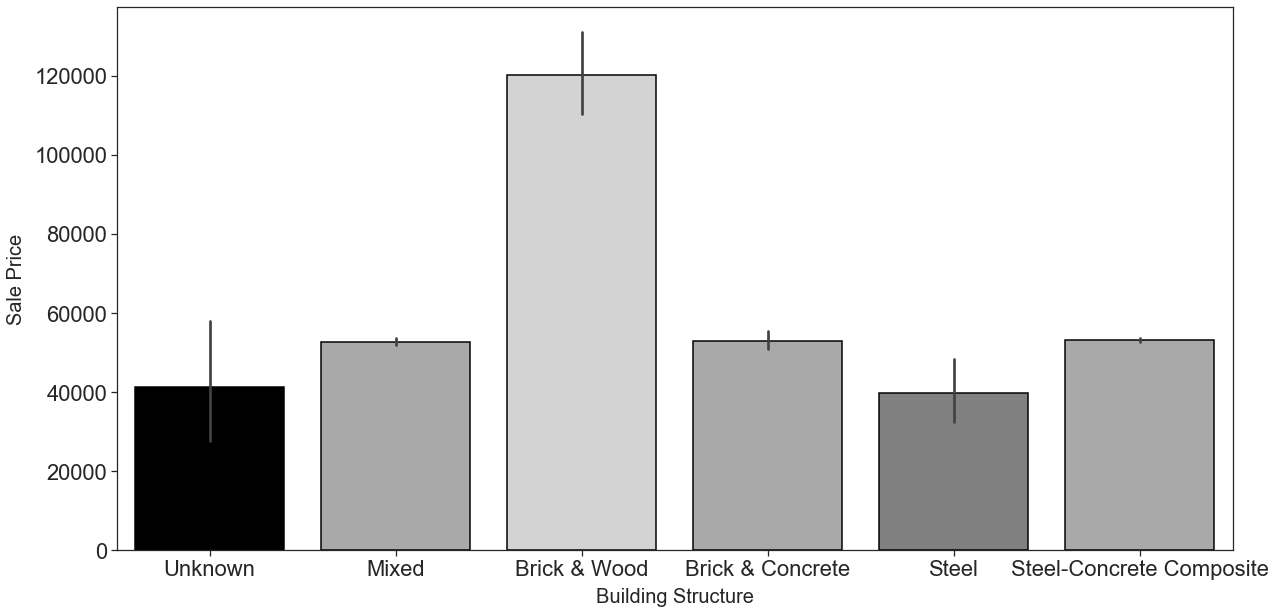

In [251]:
plt.figure(figsize = (20,10))
ax = sns.barplot(x = 'buildingStructure', y = 'price', data = df,
                 #palette = ['gray', 'lightsteelblue', 'steelblue', 'lightsteelblue', 'steelblue', 'lightsteelblue'],
                 palette = ['black', 'darkgray', 'lightgray', 'darkgray', 'gray', 'darkgray'],
                 linewidth = 1.5, edgecolor = 'black')
plt.xlabel('Building Structure', 
           fontdict = {'fontsize':20}, labelpad = 8)
plt.ylabel('Sale Price', fontdict = {'fontsize':20}, labelpad = 8)
ax.set_xticklabels(['Unknown', 'Mixed', 'Brick & Wood', 'Brick & Concrete', 'Steel', 'Steel-Concrete Composite'])
plt.savefig('buildingStructure.png')

It seems that in terms of `buildingStructure`, `mixed`, `brick & concrete` and `steel-concrete composite` all have low variance and lower sale price, `brick & wood` and `steel` have higher variance and relatively higher sale price.

In [21]:
#df['buildingStructure1'] = df['buildingStructure'].map(lambda x: 1 if x in [2, 4, 6] else 0)
#df['buildingStructure2'] = df['buildingStructure'].map(lambda x: 1 if x in [3, 5] else 0)
#df.drop(columns = 'buildingStructure', inplace = True)

In [230]:
df['buildingStructure1'] = df['buildingStructure'].map(lambda x: 1 if x in [1] else 0)
df['buildingStructure2'] = df['buildingStructure'].map(lambda x: 1 if x in [2] else 0)
df['buildingStructure3'] = df['buildingStructure'].map(lambda x: 1 if x in [3] else 0)
df['buildingStructure4'] = df['buildingStructure'].map(lambda x: 1 if x in [4] else 0)
df['buildingStructure5'] = df['buildingStructure'].map(lambda x: 1 if x in [5] else 0)
df['buildingStructure6'] = df['buildingStructure'].map(lambda x: 1 if x in [6] else 0)
#df.drop(columns = 'buildingStructure', inplace = True)

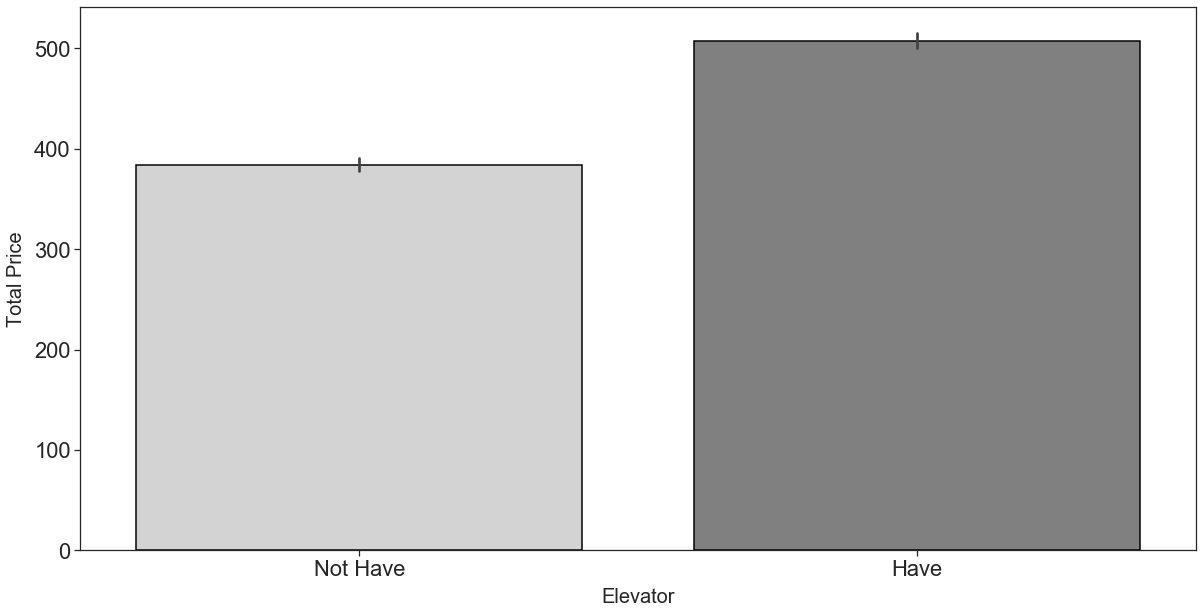

In [256]:
plt.figure(figsize = (20,10))
ax = sns.barplot(x = 'elevator', y = 'totalPrice', data = df,
                 palette = ['lightgrey', 'grey'],
                 linewidth = 1.5, edgecolor = 'black')
plt.xlabel('Elevator', 
           fontdict = {'fontsize':20}, labelpad = 8)
plt.ylabel('Total Price', fontdict = {'fontsize':20}, labelpad = 8)
ax.set_xticklabels(['Not Have', 'Have'])
plt.show()
#plt.savefig('elevator.png')

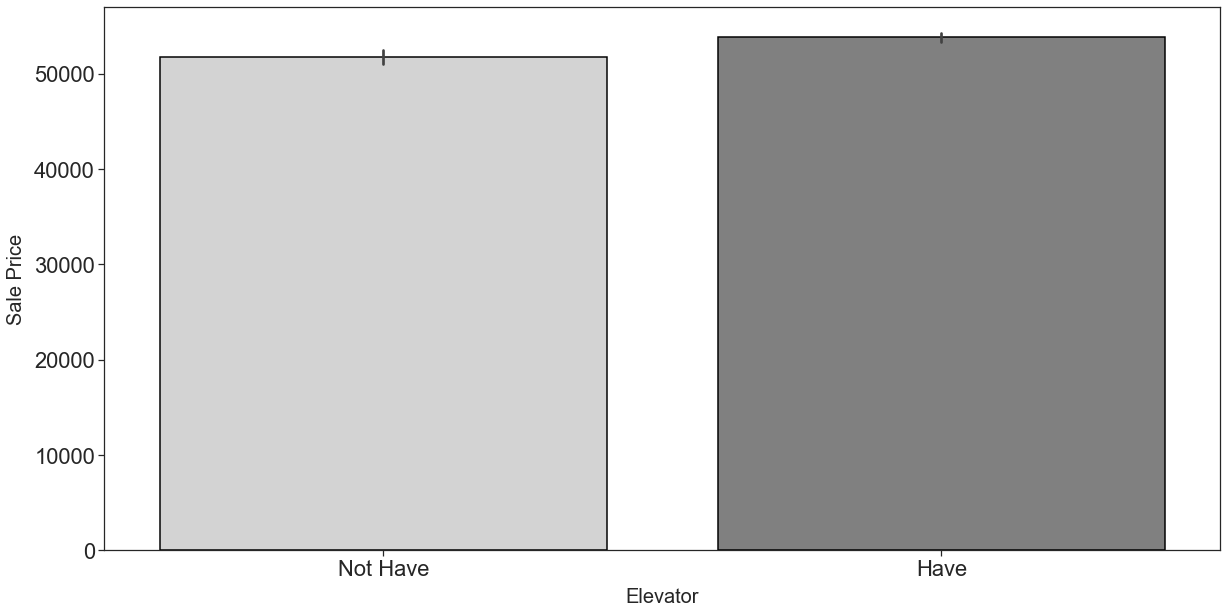

In [252]:
plt.figure(figsize = (20,10))
ax = sns.barplot(x = 'elevator', y = 'price', data = df,
                 palette = ['lightgrey', 'grey'],
                 linewidth = 1.5, edgecolor = 'black')
plt.xlabel('Elevator', 
           fontdict = {'fontsize':20}, labelpad = 8)
plt.ylabel('Sale Price', fontdict = {'fontsize':20}, labelpad = 8)
ax.set_xticklabels(['Not Have', 'Have'])
plt.savefig('elevator.png')

This makes sense. Houses with elevators are probably newer, higher buildings, so they generally have higher prices than houses without elevators.

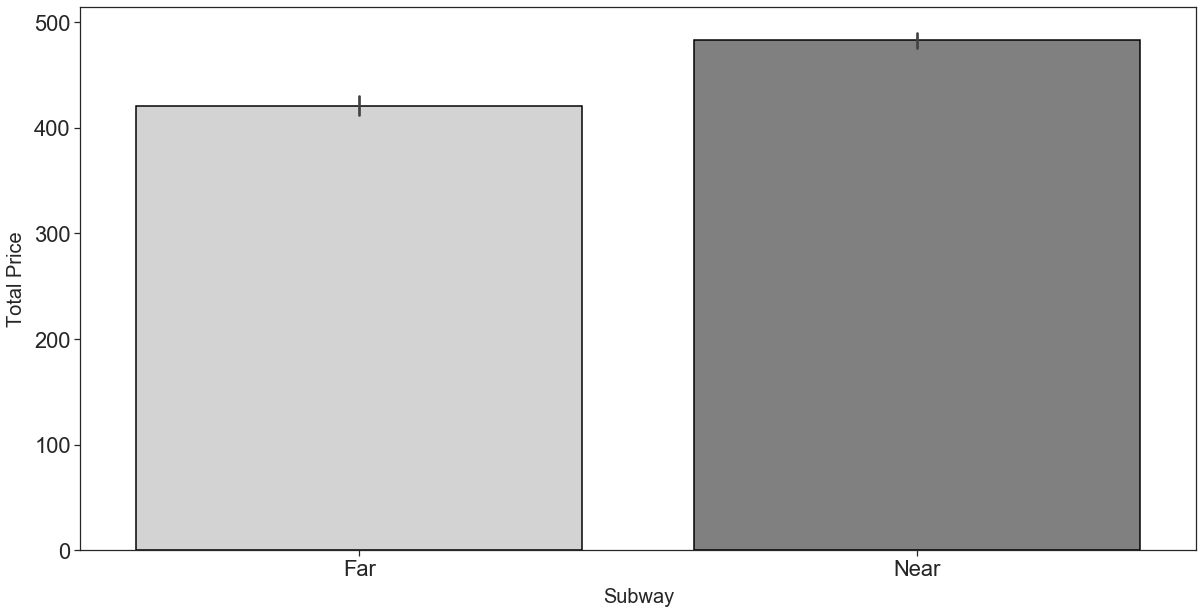

In [257]:
plt.figure(figsize = (20,10))
ax = sns.barplot(x = 'subway', y = 'totalPrice', data = df,
                 palette = ['lightgrey', 'grey'],
                 linewidth = 1.5, edgecolor = 'black')
plt.xlabel('Subway', 
           fontdict = {'fontsize':20}, labelpad = 8)
plt.ylabel('Total Price', fontdict = {'fontsize':20}, labelpad = 8)
ax.set_xticklabels(['Far', 'Near'])
plt.show()
#plt.savefig('subway.png')

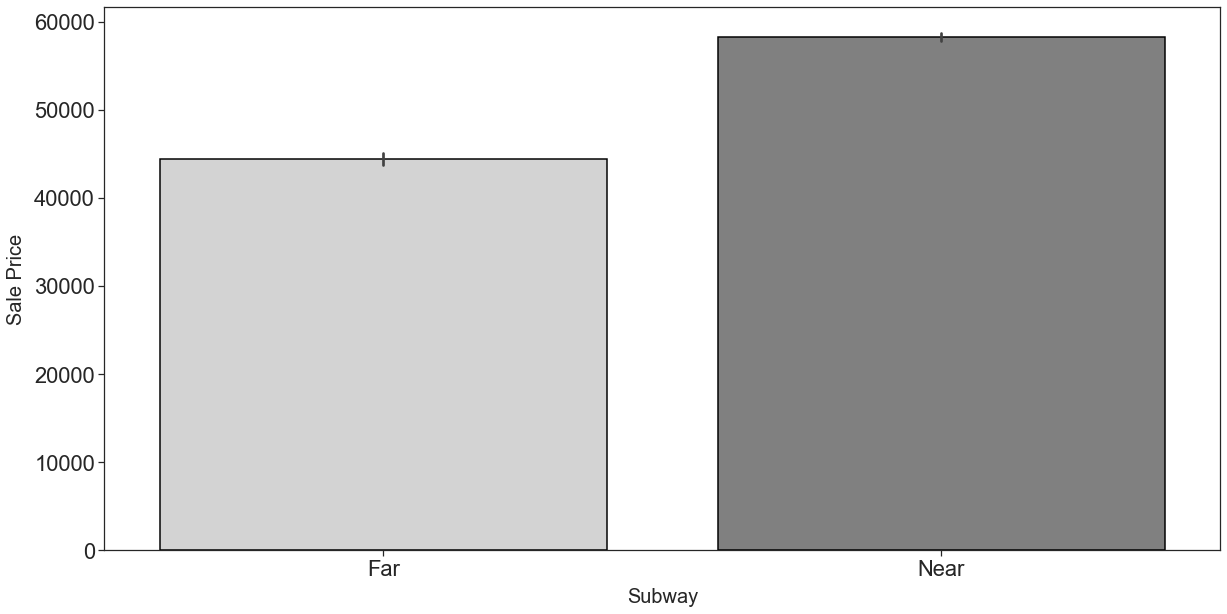

In [253]:
plt.figure(figsize = (20,10))
ax = sns.barplot(x = 'subway', y = 'price', data = df,
                 palette = ['lightgrey', 'grey'],
                 linewidth = 1.5, edgecolor = 'black')
plt.xlabel('Subway', 
           fontdict = {'fontsize':20}, labelpad = 8)
plt.ylabel('Sale Price', fontdict = {'fontsize':20}, labelpad = 8)
ax.set_xticklabels(['Far', 'Near'])
plt.savefig('subway.png')

As we would expect, houses near subway stations should have higher prices since it is more convenient. However, what was surprising to me was that the price difference isn't really big between the two, and certainly not as big as the price difference for elevators. 

**I was originally using `totalPrice` when I made the comment above, and the result flipped when I used `price` instead!!**

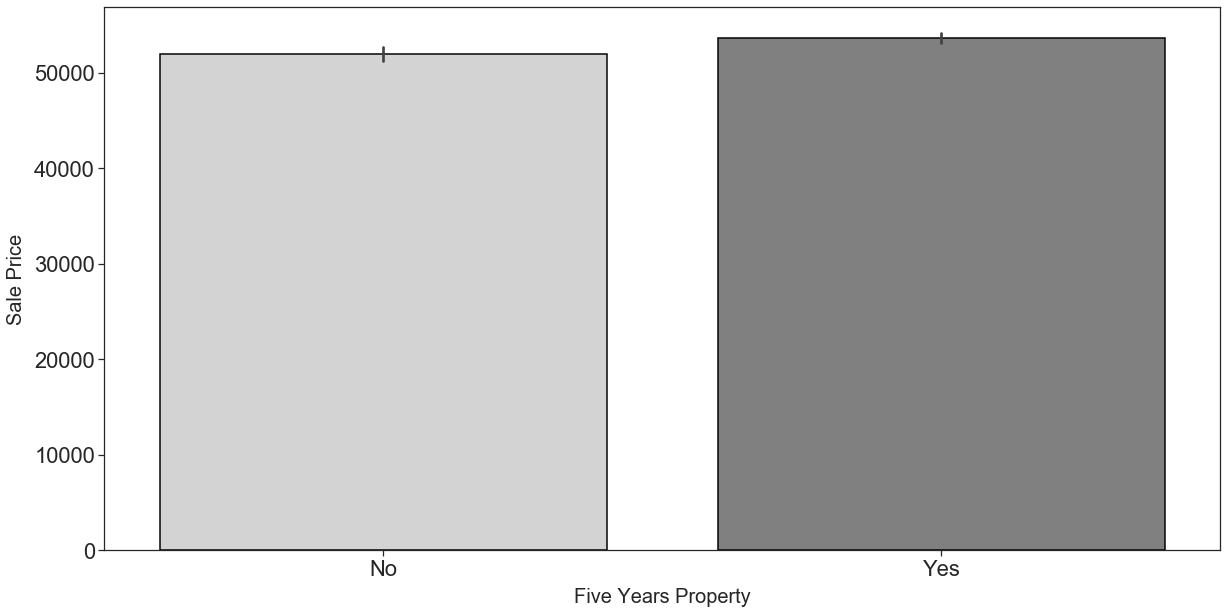

In [262]:
plt.figure(figsize = (20,10))
ax = sns.barplot(x = 'fiveYearsProperty', y = 'price', data = df,
                 palette = ['lightgrey', 'grey'],
                 linewidth = 1.5, edgecolor = 'black')
plt.xlabel('Five Years Property', 
           fontdict = {'fontsize':20}, labelpad = 8)
plt.ylabel('Sale Price', fontdict = {'fontsize':20}, labelpad = 8)
ax.set_xticklabels(['No', 'Yes'])
plt.savefig('fiveYearsProperty.png')

In [25]:
#df.dtypes

We see that `constructionTime` is currently counted as `object` when it should be numerical/ordinal.

In [26]:
#dict(df['constructionTime'].value_counts())

We also see that we cannot directly convert it to integer because some values are invalid.

In [27]:
df['constructionTime'] = df[df['constructionTime']!='????']['constructionTime'].astype(int)
df['constructionTime']

0        2005.0
1        2004.0
2        2005.0
3        2008.0
4        1960.0
          ...  
10624    2002.0
10625    2005.0
10626    1990.0
10627    2011.0
10628    1990.0
Name: constructionTime, Length: 10629, dtype: float64

Not sure why it is converting to float instead of integer but at least it is numerical which we can work with.

In [28]:
years = [int(year) for year in sorted(list(dict(df['constructionTime'].value_counts()).keys()))]

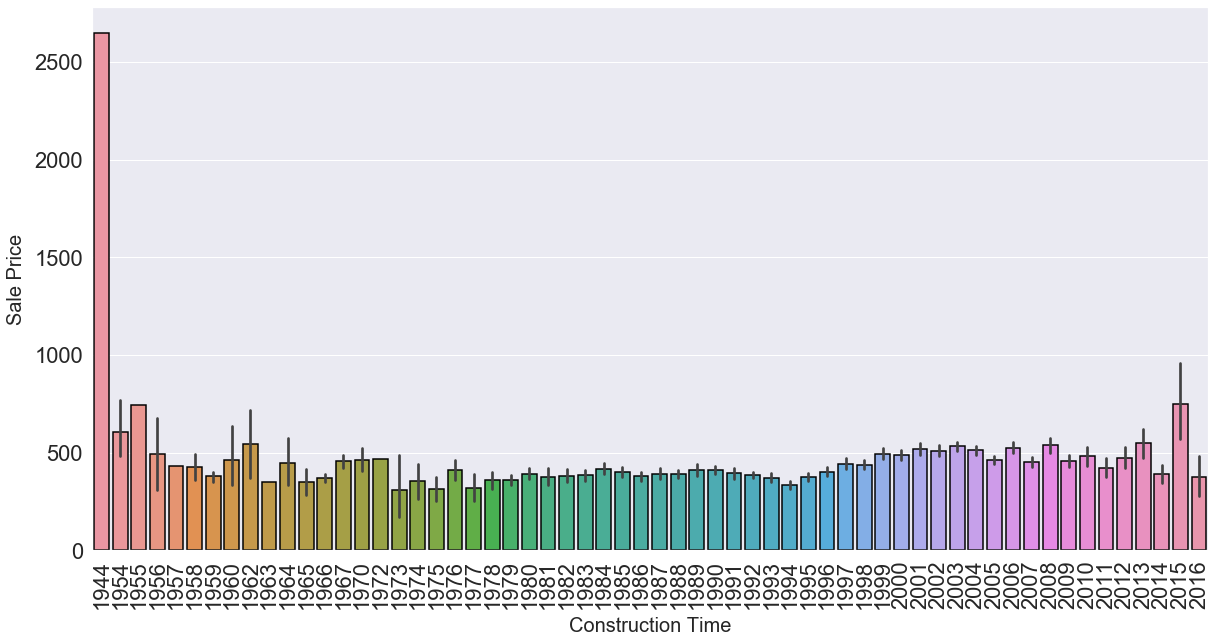

In [29]:
plt.figure(figsize = (20,10))
ax = sns.barplot(x = 'constructionTime', y = 'totalPrice', data = df,
#                 palette = ['lightsteelblue', 'steelblue'],
                 linewidth = 1.5, edgecolor = 'black')
plt.xlabel('Construction Time', 
           fontdict = {'fontsize':20}, labelpad = 8)
plt.ylabel('Sale Price', fontdict = {'fontsize':20}, labelpad = 8)
ax.set_xticklabels(years, rotation=90)
plt.savefig('constructionTime.png')

Not sure why 1944 is so much higher than any other year, could be an outlier/dirty data?

### Step 3: Model Preparation

After finishing exploring the data and engineering features, I want to prepare my data for modeling. 

Here I would drop time series data first because it is slightly more complicated to deal with.

So the data I would be dropping are: `url`, `id`, `Cid` because it is just miscellaneous information, `tradeTime` because time-series data is a bit more complicated to deal with, and `buildingStructure`, `renovationCondition` because we already dealt with it in the previous engineering step.

In [162]:
df.columns

Index(['url', 'id', 'Lng', 'Lat', 'Cid', 'tradeTime', 'DOM', 'followers',
       'totalPrice', 'price', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
       'bathRoom', 'buildingType', 'constructionTime', 'renovationCondition',
       'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty',
       'subway', 'buildingType1', 'buildingType2', 'renovationCondition1',
       'renovationCondition2', 'buildingStructure1', 'buildingStructure2',
       'Lng_diff', 'Lat_diff', 'Lng_quad', 'Lat_quad'],
      dtype='object')

In [163]:
new_df = df[['Lng', 'Lat', 'DOM', 'followers',
       'totalPrice', 'price', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
       'bathRoom', 'buildingType', 'renovationCondition',
       'buildingStructure', 'ladderRatio', 'elevator', 'fiveYearsProperty',
       'subway', 'buildingType1', 'buildingType2', 'renovationCondition1',
       'renovationCondition2', 'buildingStructure1', 'buildingStructure2',
        'Lng_diff', 'Lat_diff', 'Lng_quad', 'Lat_quad']]
new_df.head(3)

,Lng,Lat,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,...,buildingType1,buildingType2,renovationCondition1,renovationCondition2,buildingStructure1,buildingStructure2,Lng_diff,Lat_diff,Lng_quad,Lat_quad
0,116.475489,40.019520,1464,106,415.0,31680,131.00,2,1,1,...,1,0,1,0,1,0,0.068889,0.137320,13566.539538,1601.561981
1,116.453917,39.881534,903,126,575.0,43436,132.38,2,2,1,...,1,0,0,1,1,0,0.047317,0.000666,13561.514785,1590.536754
2,116.561978,39.877145,1271,48,1030.0,52021,198.00,3,2,1,...,1,0,1,0,1,0,0.155378,0.005055,13586.694715,1590.186693


In [164]:
pd.get_dummies(new_df)

,Lng,Lat,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,...,buildingType1,buildingType2,renovationCondition1,renovationCondition2,buildingStructure1,buildingStructure2,Lng_diff,Lat_diff,Lng_quad,Lat_quad
0,116.475489,40.019520,1464,106,415.0,31680,131.00,2,1,1,...,1,0,1,0,1,0,0.068889,0.137320,13566.539538,1601.561981
1,116.453917,39.881534,903,126,575.0,43436,132.38,2,2,1,...,1,0,0,1,1,0,0.047317,0.000666,13561.514785,1590.536754
2,116.561978,39.877145,1271,48,1030.0,52021,198.00,3,2,1,...,1,0,1,0,1,0,0.155378,0.005055,13586.694715,1590.186693
3,116.438010,40.076114,965,138,297.5,22202,134.00,3,1,1,...,1,0,1,0,1,0,0.031410,0.193914,13557.810173,1606.094913
4,116.428392,39.886229,927,286,392.0,48396,81.00,2,1,1,...,1,0,0,1,1,0,0.021792,0.004029,13555.570464,1590.911264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10624,116.478366,39.941392,139,52,1160.0,50922,227.80,3,2,1,...,1,0,0,1,1,0,0.071766,0.059192,13567.209746,1595.314795
10625,116.370937,39.889555,96,12,448.0,61888,72.39,1,1,1,...,1,0,1,0,1,0,0.035663,0.007355,13542.194978,1591.176598
10626,116.442298,39.970551,23,93,218.0,53171,41.00,1,1,1,...,1,0,1,0,1,0,0.035698,0.088351,13558.808764,1597.644947
10627,116.425063,40.044097,84,7,178.0,31168,57.11,1,1,1,...,1,0,0,1,1,0,0.018463,0.161897,13554.795295,1603.529705


After dealing with the data and dropping the columns we don't need, can't deal with, or already dealt with, we can see that no more additional categorical variables of interest needs to be dummified, and the columns before and after dummifying remains the same.

Next, we split data into training and testing sets using `train_test_split()` as the original author suggests. *Alternatively, we could also use `StratifiedShuffleSplit` which is a more robust method with cross-validation.*

In [165]:
new_df.columns

Index(['Lng', 'Lat', 'DOM', 'followers', 'totalPrice', 'price', 'square',
       'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'buildingType',
       'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator',
       'fiveYearsProperty', 'subway', 'buildingType1', 'buildingType2',
       'renovationCondition1', 'renovationCondition2', 'buildingStructure1',
       'buildingStructure2', 'Lng_diff', 'Lat_diff', 'Lng_quad', 'Lat_quad'],
      dtype='object')

In [92]:
# before engineered original; drop buildingType
X_full = df[['Lng', 'Lat', 'DOM', 'followers', 'price', 'square',
       'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom',
       'renovationCondition', 'buildingStructure',  'ladderRatio', 'elevator',
       'fiveYearsProperty', 'subway']]

In [38]:
y = df['totalPrice']

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.33, random_state=42)

In [88]:
corr_matrix = new_df.corr()[['totalPrice']].sort_values('totalPrice')
corr_target = abs(corr_matrix)
corr_target.sort_values('totalPrice', ascending=False)

,totalPrice
totalPrice,1.000000
square,0.680122
bathRoom,0.563007
livingRoom,0.515816
price,0.506238
drawingRoom,0.440815
ladderRatio,0.327885
elevator,0.203580
buildingStructure,0.196751
DOM,0.145440


I noticed that `renovationCondition1/2` have higher correlation than original, which means that engineering the features were helpful. However, `buildingType` and `bulidingStructure` seem to have got lower :(

In [60]:
# correlation > 0.5
X1 = df[['price', 'square', 'livingRoom', 'bathRoom']]

In [61]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.33, random_state=42)

I don't know if I should drop `price` and `square` because they are directly related to `totalPrice`. But then we only have two variables with correlation higher than 0.5.

In [64]:
# correlation > 0.5; drop price
X11 = df[['square', 'livingRoom', 'bathRoom']]
X_train11, X_test11, y_train11, y_test11 = train_test_split(X11, y, test_size=0.33, random_state=42)

In [65]:
# correlation > 0.5; drop square
X12 = df[['price', 'livingRoom', 'bathRoom']]
X_train12, X_test12, y_train12, y_test12 = train_test_split(X12, y, test_size=0.33, random_state=42)

In [66]:
# correlation > 0.5; drop price and square
X13 = df[['livingRoom', 'bathRoom']]
X_train13, X_test13, y_train13, y_test13 = train_test_split(X13, y, test_size=0.33, random_state=42)

In [73]:
# correlation > 0.3
X2 = df[['price', 'square', 'livingRoom', 'bathRoom', 'drawingRoom', 'ladderRatio']]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.33, random_state=42)

In [78]:
# correlation > 0.3 and engineered
X3 = df[['Lng', 'Lat', 'DOM', 'followers', 'price', 'square',
       'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom',
       'ladderRatio', 'elevator',
       'fiveYearsProperty', 'subway', 
       'buildingType1', 'buildingType2',
       'renovationCondition1', 'renovationCondition2', 
       'buildingStructure1', 'buildingStructure2']]
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.33, random_state=42)

### Step 4: Modeling

Modeling is an iterative process in which several models were built in order to inform my final model. In total, the author built six models. All models were evaluated using the R2 score.

In [40]:
def display_R2_scores(model, X_train, y_train, X_test, y_test):
    print(f'The mean cross validation score for this model is {round(cross_val_score(model, X_train, y_train).mean(),4)}.')
    print(f'The training score for this model is {round(model.score(X_train, y_train), 4)}.')
    print(f'The testing score for this model is {round(model.score(X_test, y_test),4)}.')

#### Model 1: 
This model was the baseline/null model created using `DummyRegressor()`. It was conducted to explore the R2 score when the mean was predicted for each observation.

In [89]:
dr = DummyRegressor()
dr.fit(X_train, y_train)

DummyRegressor()

In [90]:
display_R2_scores(dr, X_train, y_train, X_test, y_test)

The mean cross validation score for this model is -0.0004.
The training score for this model is 0.0.
The testing score for this model is -0.0011.


#### Model 2: 
This model was a linear regression model using features identified to be important during EDA.

`['price', 'square', 'livingRoom', 'bathRoom']`

In [62]:
lr = LinearRegression()
lr.fit(X_train1, y_train1)

LinearRegression()

In [63]:
display_R2_scores(lr, X_train1, y_train1, X_test1, y_test1)

The mean cross validation score for this model is 0.8639.
The training score for this model is 0.866.
The testing score for this model is 0.8671.


`['square', 'livingRoom', 'bathRoom']`

In [68]:
lr = LinearRegression()
lr.fit(X_train11, y_train11)
display_R2_scores(lr, X_train11, y_train11, X_test11, y_test11)

The mean cross validation score for this model is 0.4348.
The training score for this model is 0.4444.
The testing score for this model is 0.498.


`['price', 'livingRoom', 'bathRoom']`

In [70]:
lr = LinearRegression()
lr.fit(X_train12, y_train12)
display_R2_scores(lr, X_train12, y_train12, X_test12, y_test12)

The mean cross validation score for this model is 0.6908.
The training score for this model is 0.6921.
The testing score for this model is 0.6832.


`['livingRoom', 'bathRoom']`

In [71]:
lr = LinearRegression()
lr.fit(X_train13, y_train13)
display_R2_scores(lr, X_train13, y_train13, X_test13, y_test13)

The mean cross validation score for this model is 0.3454.
The training score for this model is 0.3518.
The testing score for this model is 0.3812.


Seems that `price` and `square` still needs to be kept.

#### Model 3: 
After seeing that the linear regression model had room for improvement, I put all possible features into a model to create an overfit model that could then be regularized.

`['price', 'square', 'livingRoom', 'bathRoom', 'drawingRoom', 'ladderRatio']`

In [75]:
lr = LinearRegression()
lr.fit(X_train2, y_train2)
display_R2_scores(lr, X_train2, y_train2, X_test2, y_test2)

The mean cross validation score for this model is 0.8648.
The training score for this model is 0.8671.
The testing score for this model is 0.8686.


`['Lng', 'Lat', 'DOM', 'followers', 'price', 'square', 'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway',  'buildingType1', 'buildingType2', 'renovationCondition1', 'renovationCondition2', 'buildingStructure1', 'buildingStructure2']`

In [79]:
lr = LinearRegression()
lr.fit(X_train3, y_train3)
display_R2_scores(lr, X_train3, y_train3, X_test3, y_test3)

The mean cross validation score for this model is 0.8653.
The training score for this model is 0.8743.
The testing score for this model is 0.8735.


`['Lng', 'Lat', 'DOM', 'followers', 'price', 'square', 'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'renovationCondition', 'buildingStructure',  'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway']`

Using original columns and dropping `buildingType` because of error

In [94]:
lr = LinearRegression()
lr.fit(X_train, y_train)
display_R2_scores(lr, X_train, y_train, X_test, y_test)

The mean cross validation score for this model is 0.8705.
The training score for this model is 0.8731.
The testing score for this model is 0.8743.


We currently have the higher training and testing scores when putting literally all the variables in. Doesn't really make sense and also how is the testing score better than the traing score???

#### Model 4: 
The first type of regularization that I tried was Ridge Regression, which uses an L2 penalty.

In [95]:
# Scale the data
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)
#scaled_holdout = ss.transform(X_holdout)

# Model
ridge = Ridge(alpha = 1025) 
ridge = ridge.fit(Z_train, y_train)

In [96]:
display_R2_scores(ridge, X_train, y_train, X_test, y_test)

The mean cross validation score for this model is 0.8694.
The training score for this model is -961610979.011.
The testing score for this model is -789140917.3609.


Not sure why but the training and testing score seem off.

### Model 5: 
The second type of regularization that I tried was LASSO Regression.

In [97]:
lasso = Lasso(alpha = 5000, max_iter = 4000)
lasso.fit(Z_train, y_train)

Lasso(alpha=5000, max_iter=4000)

In [98]:
display_R2_scores(lasso, X_train, y_train, X_test, y_test)

The mean cross validation score for this model is 0.7179.
The training score for this model is 0.0.
The testing score for this model is -0.0011.


#### Model 6: 
*The final model was a linear regression with features identified to be important during EDA and the LASSO regression. Because the target was not normally distributed, for this model, it was log-transformed.*

Our final model is putting everything in and not engineering it???

In [52]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [53]:
display_R2_scores(lr, X_train, y_train, X_test, y_test)

The mean cross validation score for this model is 0.8664.
The training score for this model is 0.8753.
The testing score for this model is 0.8744.


### Step 6: Model Evaluation

In [103]:
lr.coef_

array([ 1.37114512e+01,  5.09965542e+00,  1.29700993e-02,  7.00394118e-02,
        8.30423996e-03,  4.72773118e+00, -6.77307244e-01, -1.33201773e+00,
        3.67985278e+01,  1.81648959e+00,  3.68895611e+00,  7.17908161e+00,
        7.08721977e+01,  1.82069582e+01, -9.99810947e+00,  7.00705968e+00])

In [104]:
lr.intercept_

-2330.0569394532945

In [120]:
y_hat = lr.predict(X_test)

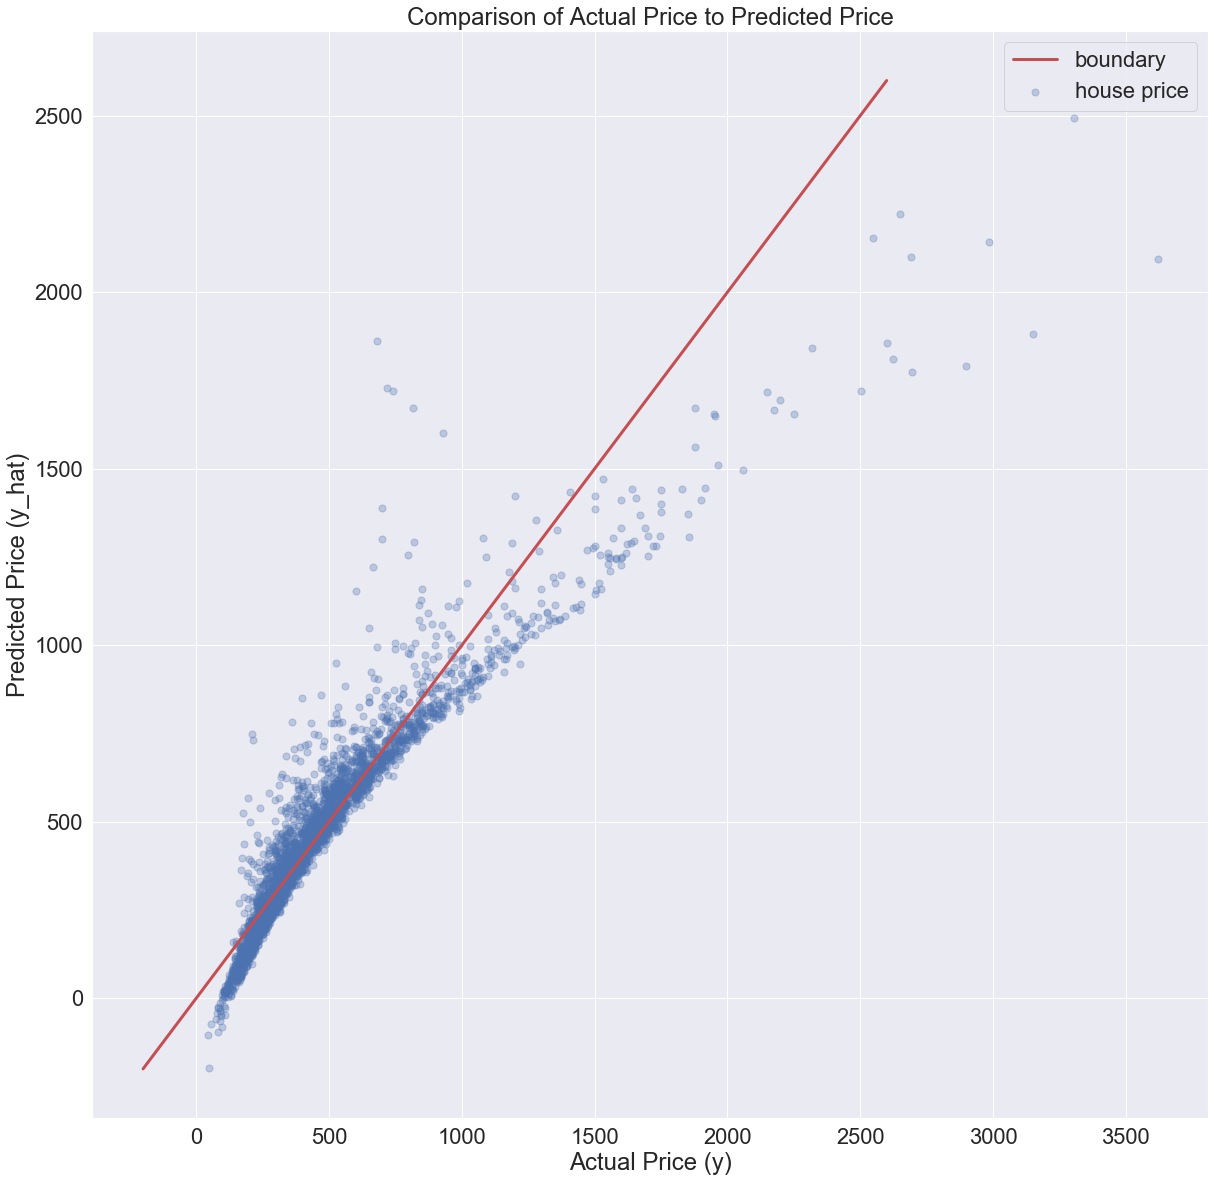

<Figure size 432x288 with 0 Axes>

In [141]:
# only plotting test data here or else it would be really filled
plt.figure(figsize=(20,20))
plt.scatter(y_test, y_hat, alpha=0.3, s=50, label='house price')
plt.plot([-200,2600], [-200,2600], c='r', linewidth=3, label='boundary')
plt.xlabel('Actual Price (y)')
plt.ylabel('Predicted Price (y_hat)')
plt.title('Comparison of Actual Price to Predicted Price')
plt.legend()
plt.show()
plt.savefig('predicted_truth_compare.png')